# BANA780 Problem 5: Predictive Analysis 2
#### Team Members:
Christine Dorward<br>
Sarah Lazio-Maimone<br>
Adit Shetty<br>
Lea Stavoli<br>
Mind Tienpasertkij<br>

For the last assignment of the course, we are to work in teams to complete a predictive analysis. As a team, we are to identify an organization with a business problem that can benefit from predictive analysis and/or machine learning. The deliverables are to include a project plan, report, and presentation.

We chose a Kaggle competition to predict movie box office revenues as our problem project.

## Project Plan
### Statement of Work
Description of Project: Using Kaggle’s Box Office Prediction Data set located at https://www.kaggle.com/c/tmdb-box-office-prediction, the team will work together to analyze movie data and develop a model that will predict if certain characteristics of films lead to higher or lower box office revenue.

Schedule: 
- Begin developing Project Plan 4/27/21
- First group meeting to finalize Statement of Work 5/2/21

Deliverables: 
- Statement of Work due Monday 5/3/21
- Presentation to Professor Perroti due Tuesday 5/11/21
- Final project report deliverables due Wednesday 5/12/21

### Assignment of Responsibilities

We will all contribute equally to the project, but have assigned leads to specific tasks/techniques to best manage the workload:<br>
- Data Acquisition and Wrangling: Lea Stavoli
- Exploratory Data Analysis (EDA) / Feature Engineering: Sarah Lazio-Maimone
- Machine Learning and Predictive Modeling: Adit Shetty, Christine Dorward
- Application and Analysis: Mind Tienpasertkij
- Report and Presentation: Mind Tienpasertkij, Adit Shetty

### Techniques to Apply

- Create a compelling analysis with in-depth EDA and Feature Engineering
- Create visualizations at all stages of the project to be used in the report and presentation
- Run multiple predictive models, such as Linear Regression, Neural Network Regression, Random Forest Classifier and Light Gradient Boosting Classifier, to find the most accurate predictions.



In [1]:
#import libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import re
import joblib
import multiprocessing
import datetime
from PIL import Image
import time

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import scipy.stats as ss
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split,KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn import model_selection
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer

from urllib.request import urlopen
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
stop = set(stopwords.words('english'))

import os
import json
import ast
import eli5
import shap

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

The objective of the competition is to predict worldwide box office revenue for the movies provided in the dataset.

Training and testing data files are provided with over 7000 rows (movies) total. The first steps are to import various packages, then read in and explore the files to see the data included, column names, structure, number of observations, unique variables, etc. The Kaggle competition hosts stated there are no duplicate movies although there may appear to be due to remakes, multiple films with the same name, etc. There is a unique ID number for each movie to retain their unique attributes.

In [84]:
#load data
train = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
test = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')
submission = pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')

In [82]:
#3000 rows in the train set and 4398 in the test
print('train dataset shape is {}'.format(train.shape))
print('test dataset shape is {}'.format(test.shape))

train dataset shape is (3000, 31)
test dataset shape is (4398, 22)


In [85]:
print("- The target is: \n{} ".format([item for item in train.columns.tolist() if item not in test.columns.tolist()]))
print(train["".join([item for item in train.columns.tolist() if item not in test.columns.tolist()])].dtypes)

- The target is: 
['revenue'] 
int64


In [4]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


The data files are not overwhelmingly large, but a good size for this type of analysis. The training dataset has 23 columns with over 3,000 observations, or rows, of data. The test dataset has 22 columns with 4,398 observations (intentionally missing the revenue column, which is the target). From the data sample above, we can see several columns are in dictionary form (JSON format), which will need to be reformatted to be useful in the analysis.

We sample code from several great notebooks on the Kaggle competition site to aid in the completion of this project.

### Attribute Explanation
This column description was shared on many competitors' notebooks, this is just one: https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat

**ID** - Integer unique id of each movie

**Belongs_to_collection** - Contains the TMDB Id, Name, Movie Poster and Backdrop URL of a movie in JSON format. You can see the Poster and Backdrop Image like this: https://image.tmdb.org/t/p/original/. Example: https://image.tmdb.org/t/p/original//iEhb00TGPucF0b4joM1ieyY026U.jpg

**Budget** - Budget of a movie in dollars. 0 values mean unknown

**Genres** - Contains all the Genres Name & TMDB Id in JSON Format

**Homepage** - Contains the official homepage URL of a movie. Example: http://sonyclassics.com/whiplash/ , this is the homepage of Whiplash movie

**Imdb_id** - IMDB id of a movie (string). You can visit the IMDB Page like this: https://www.imdb.com/title/

**Original_language** - Two digit code of the original language, in which the movie was made. Like: en = English, fr = french

**Original_title** - The original title of a movie. Title & Original title may differ, if the original title is not in English

**Overview** - Brief description of the movie

**Popularity** - Popularity of the movie in float

**Poster_path** - Poster path of a movie. You can see the full image like this: https://image.tmdb.org/t/p/original/

**Production_companies** - All production company name and TMDB id in JSON format of a movie

**Production_countries** - Two digit code and full name of the production company in JSON format

**Release_date** - Release date of a movie in mm/dd/yy format

**Runtime** - Total runtime of a movie in minutes (Integer)

**Spoken_languages** - Two digit code and full name of the spoken language.

**Status** - Is the movie released or rumored?

**Tagline** - Tagline of a movie

**Title** - English title of a movie

**Keywords** - TMDB Id and name of all the keywords in JSON format

**Cast** - All cast TMDB id, name, character name, gender (1 = Female, 2 = Male) in JSON format

**Crew** - Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc.

**Revenue** - Total revenue earned by a movie in dollars

In [106]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt 
# creates a table of important stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['% Missing'] = summary['Missing'] / df.shape[0] * 100    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(ss.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary


In [107]:
#2 columns standout with a majority of null values belongs_to_collection and homepage
resumetable(train)

Dataset Shape: (3000, 32)


,Name,dtypes,Missing,% Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,0.000000,3000,1,2,3,11.55
1,belongs_to_collection,object,2396,79.866667,422,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...","[{'id': 107674, 'name': 'The Princess Diaries ...",NaN,8.49
2,budget,int64,0,0.000000,404,14000000,40000000,3300000,6.05
3,genres,object,7,0.233333,872,"[{'id': 35, 'name': 'Comedy'}]","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 18, 'name': 'Drama'}]",7.93
4,homepage,object,2054,68.466667,941,NaN,NaN,http://sonyclassics.com/whiplash/,9.87
5,imdb_id,object,0,0.000000,3000,tt2637294,tt0368933,tt2582802,11.55
6,original_language,object,0,0.000000,36,en,en,en,1.15
7,original_title,object,0,0.000000,2975,Hot Tub Time Machine 2,The Princess Diaries 2: Royal Engagement,Whiplash,11.53
8,overview,object,8,0.266667,2992,"When Lou, who has become the ""father of the In...",Mia Thermopolis is now a college graduate and ...,"Under the direction of a ruthless instructor, ...",11.55
9,popularity,float64,0,0.000000,2999,6.575393,8.248895,64.29999,11.55


In [108]:
#the same two columns standout with majority of null values belongs_to_collection and homepage
resumetable(test)

Dataset Shape: (4398, 23)


,Name,dtypes,Missing,% Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,0.000000,4398,3001,3002,3003,12.10
1,belongs_to_collection,object,3521,80.059118,556,"[{'id': 34055, 'name': 'Pokémon Collection', '...",NaN,NaN,8.91
2,budget,int64,0,0.000000,513,0,88000,0,6.10
3,genres,object,16,0.363802,1101,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...","[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...","[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",8.03
4,homepage,object,2978,67.712597,1402,http://www.pokemon.com/us/movies/movie-pokemon...,NaN,NaN,10.44
5,imdb_id,object,0,0.000000,4398,tt1226251,tt0051380,tt0118556,12.10
6,original_language,object,0,0.000000,39,ja,en,en,1.16
7,original_title,object,0,0.000000,4353,ディアルガVSパルキアVSダークライ,Attack of the 50 Foot Woman,Addicted to Love,12.08
8,overview,object,14,0.318327,4383,Ash and friends (this time accompanied by newc...,When an abused wife grows to giant size becaus...,Good-natured astronomer Sam is devastated when...,12.10
9,popularity,float64,0,0.000000,4398,3.851534,3.559789,8.085194,12.10


## Exploratory Data Analysis (EDA)
We will complete a robust EDA of the dataset to best understand the variables included and how they may be useful in the predictive analysis. We will start with the JSON formatted columns to extract useful information.

In [109]:
#https://www.kaggle.com/gravix/gradient-in-a-box
#transform dictionary columns to proper format
dict_columns = ['belongs_to_collection','genres','production_companies','production_countries','spoken_languages','Keywords','cast','crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

#### Belongs_to_collection
The useful information in the first column, belongs_to_collection, is the collection name each movie is a part of and if a movie is in a collection.

In [110]:
for i, e in enumerate(train['belongs_to_collection'][:5]):
    print(i, e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}


In [111]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

<AxesSubplot:>

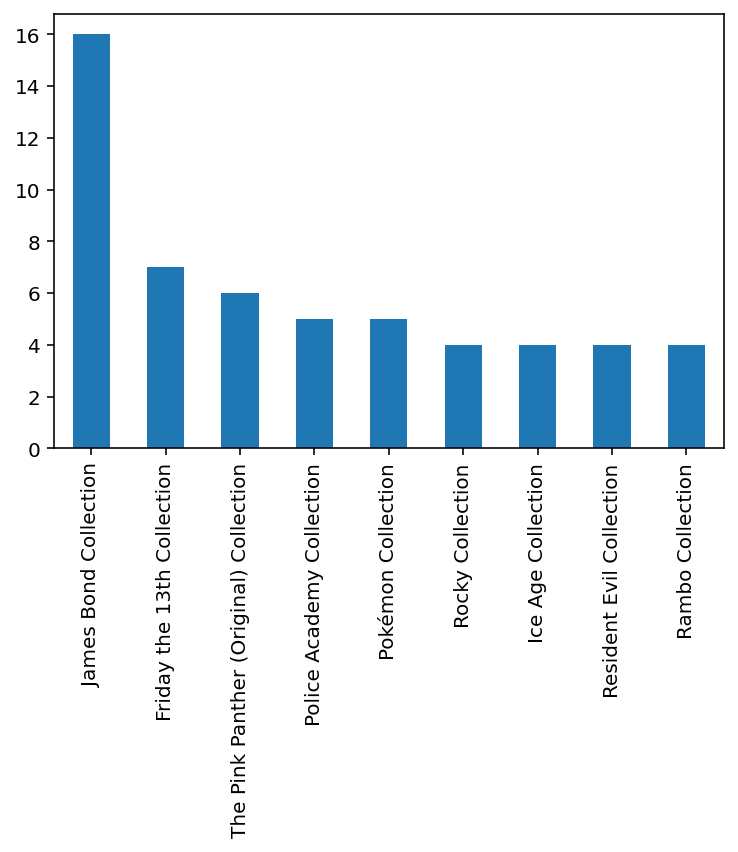

In [112]:
#top 10 collection names (remember ~80% of the rows are not part of a collection)
train['collection_name'].value_counts()[1:10].plot.bar()

#### Genres
Genres column is the name and ID number of all of the film genres a movie belongs to. Most have 2-5 genres with 0, 6, and 7 as outliers. The wordcloud and barplot below show the most common genres are drama, comedy, thriller, and action. We then created separate columns for the 15 most common genres to be used in the analysis.

In [113]:
for i, e in enumerate(train['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [114]:
print('Number of Genres of Movies')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of Genres of Movies


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [115]:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

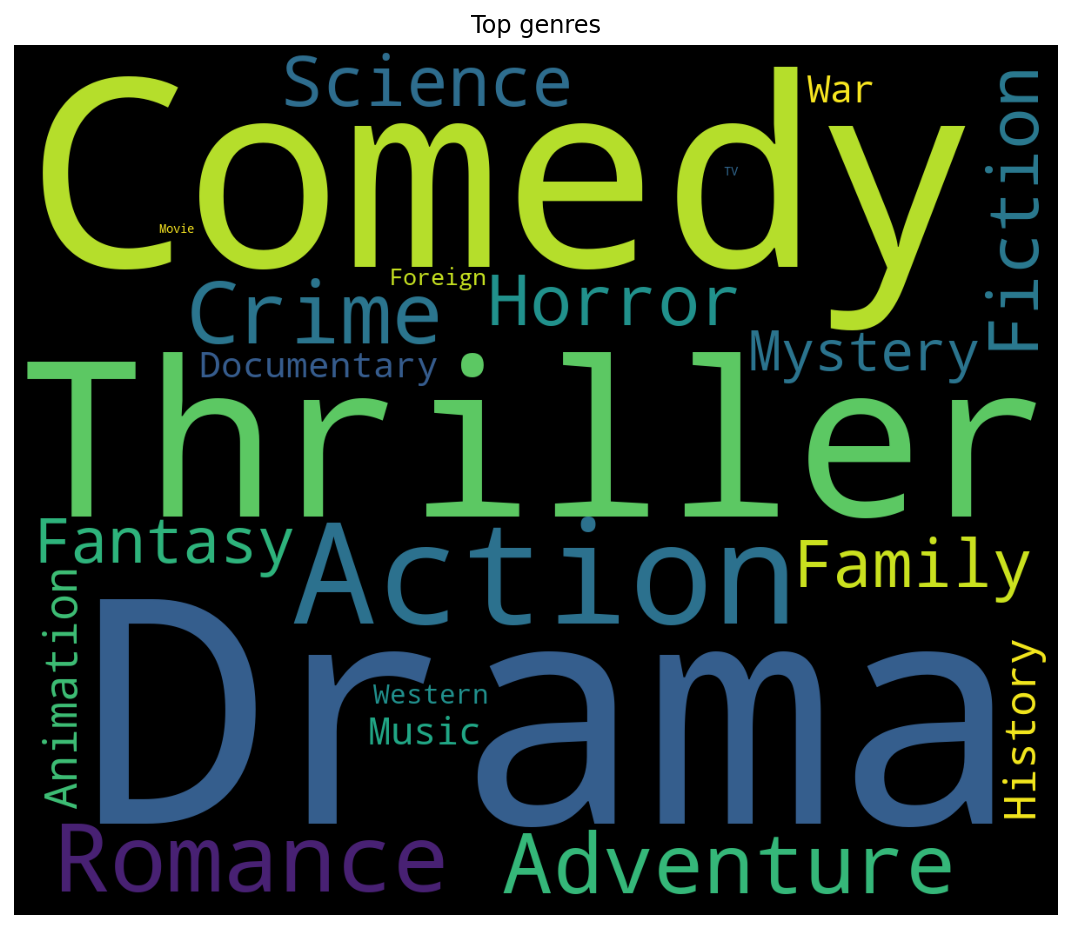

In [116]:
#wordcloud of genres
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, collocations=False, width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

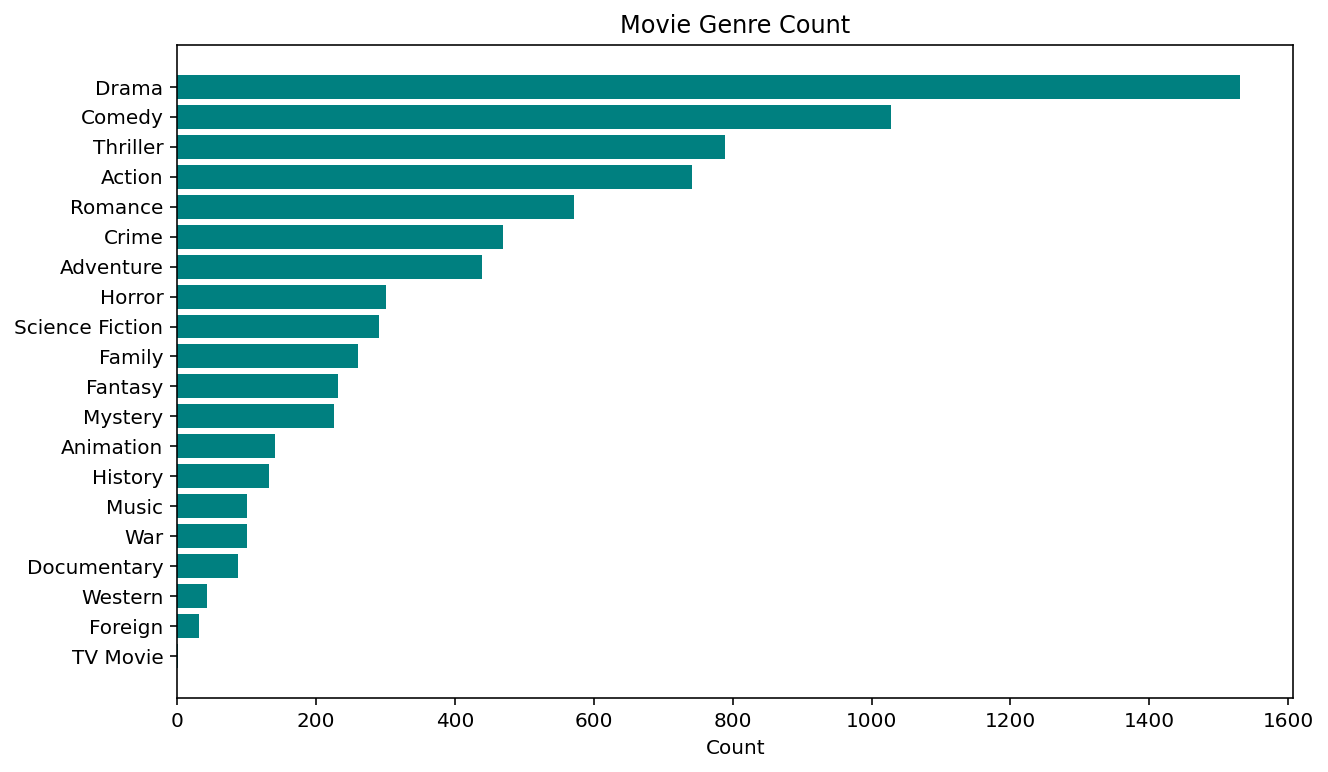

In [117]:
#barplot of the most common genres (quantitative of the wordcloud)
most_common_genres=Counter([i for j in list_of_genres for i in j]).most_common()
fig = plt.figure(figsize=(10, 6))
data=dict(most_common_genres)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='teal')
plt.xlabel('Count')
plt.title('Movie Genre Count')
plt.show()

In [119]:
#creating columns for the most common 15 genres
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

#### Production_companies
The production_companies column has the name and ID of all of the production companies involved in each film. The majority have 1-9 production companies with a few have 10 or more. Like several other competitors, it is unclear if this information will be useful in the analysis, so we will create binary columns for the 30 most common production companies.

In [122]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [123]:
print('Number of production companies in films')
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production companies in films


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
10      7
11      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

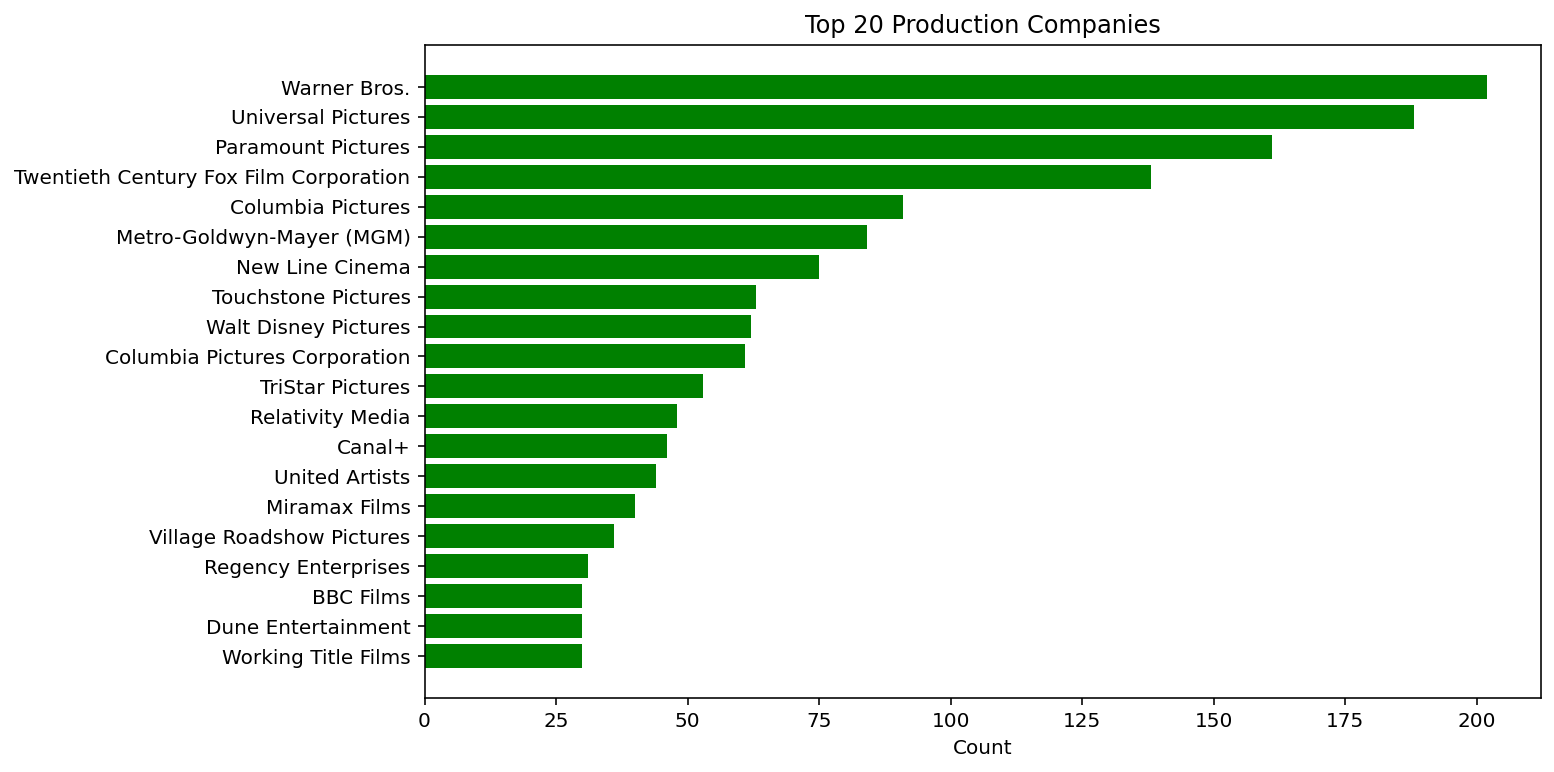

In [124]:
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

most_common_companies=Counter([i for j in list_of_companies for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_companies)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='green')
plt.xlabel('Count')
plt.title('Top 20 Production Companies')
plt.show()

In [125]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

#### Production_countries
The column shows the country name and abbreviation for all production countries involved in each film. A majority have just one production country, but can go up to five. There are just four films with more than five production countries. Similarly to the production_companies, it is unclear of this information will be useful in the analysis, so we will create binary columns for the 25 most common production countries.

In [126]:
for i, e in enumerate(train['production_countries'][:5]):
    print(i, e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [127]:
print('Number of production countries in films')
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of production countries in films


1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

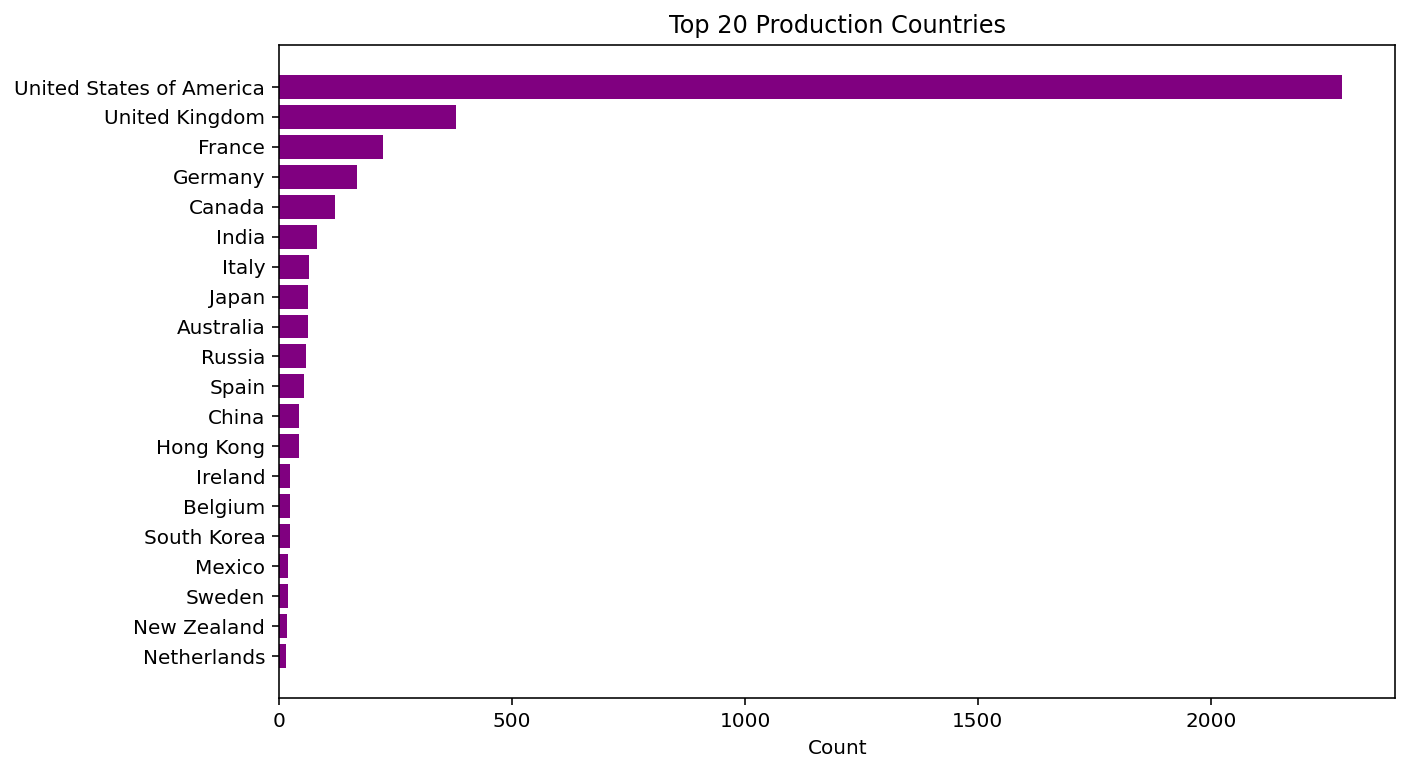

In [128]:
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
most_common_countries=Counter([i for j in list_of_countries for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_countries)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='purple')
plt.xlabel('Count')
plt.title('Top 20 Production Countries')
plt.show()

In [129]:
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

#### Spoken_languages
As shown in the barplot below, English is by far the most commonly spoken language in the films in this dataset. With such little variability in the column, it does not appear it would be a useful factor in the analysis.

In [130]:
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [131]:
print('Number of spoken languages in films')
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


1    2105
2     549
3     216
4      72
5      23
0      20
6       6
7       6
8       2
9       1
Name: spoken_languages, dtype: int64

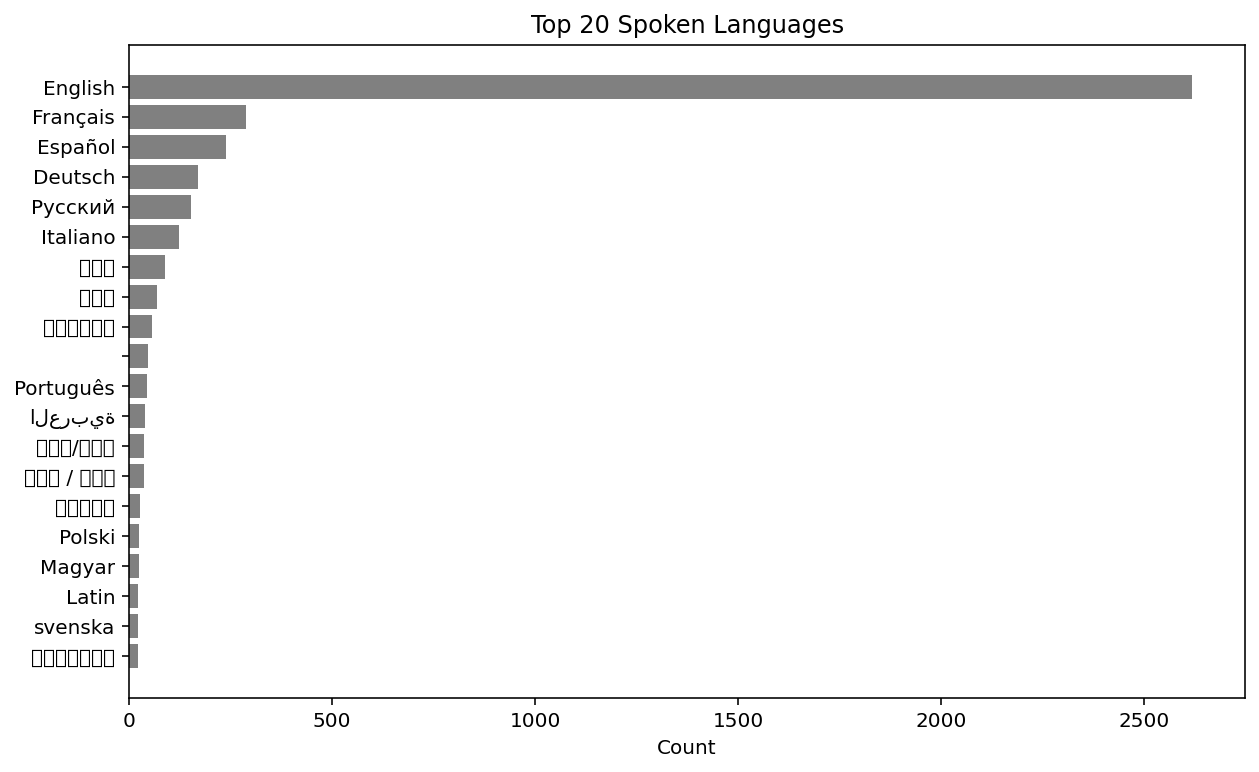

In [132]:
# English is by far the most common spoken language 
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

most_common_languages=Counter([i for j in list_of_languages for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_languages)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='gray')
plt.xlabel('Count')
plt.title('Top 20 Spoken Languages')
plt.show()

In [133]:
#didn't run this block if we agree the column isn't useful, I didn't want to add a lot of columns for no reason!
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

#### Keywords
As you would imagine, there are a lot of keywords used in films reviews and film marketing, such as woman director, independent film, and murder. To make better use of the information, we have created a column with the number of keywords used for each film and binary columns for the 30 most common keywords.

In [134]:
for i, e in enumerate(train['Keywords'][:5]):
    print(i, e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [135]:
print('Number of Keywords in films')
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of Keywords in films


5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

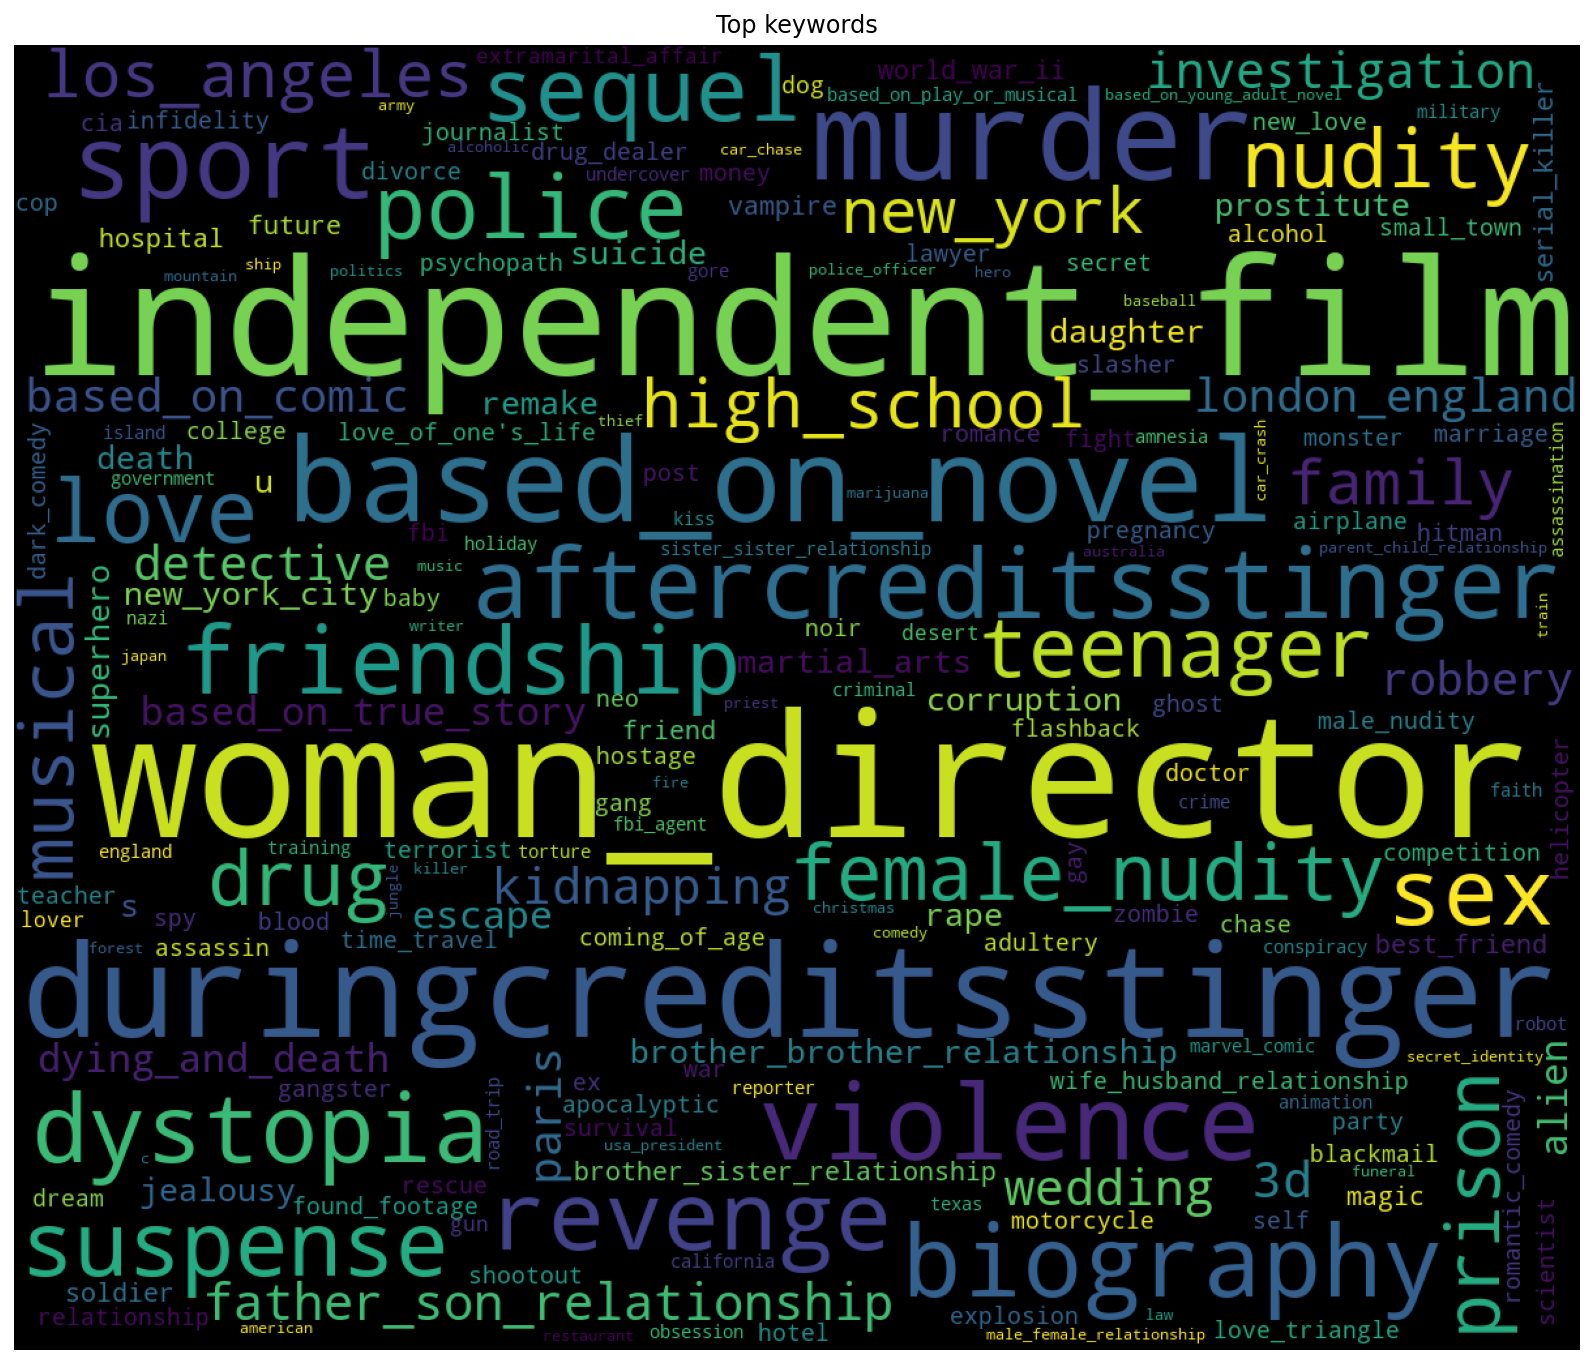

In [136]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16, 12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud2 = WordCloud(max_font_size=None, collocations=False,width=1200, height=1000).generate(text)
plt.imshow(wordcloud2)
plt.title('Top keywords')
plt.axis("off")
plt.show()

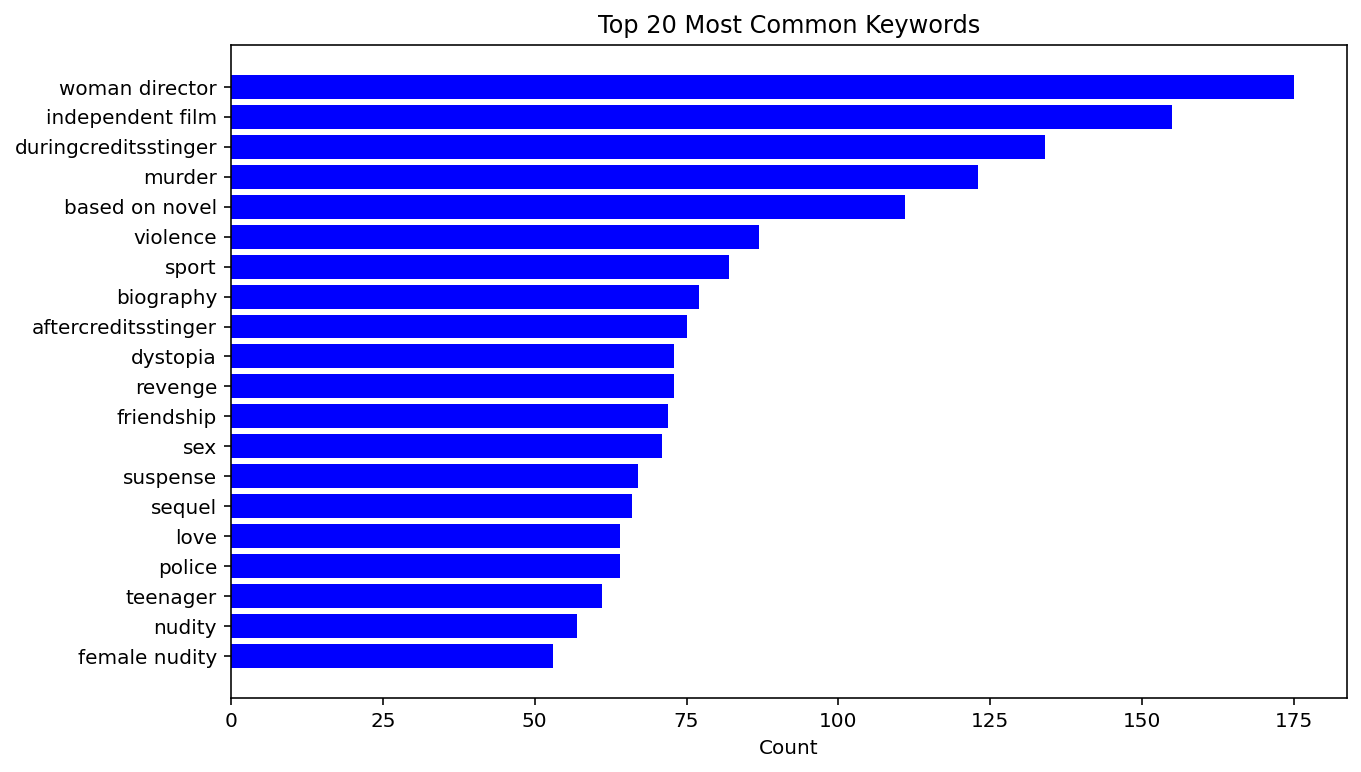

In [137]:
most_common_keywords=Counter([i for j in list_of_keywords for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_keywords)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='blue')
plt.xlabel('Count')
plt.title('Top 20 Most Common Keywords')
plt.show()

In [138]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

#### Cast
There are a lot of cast members per film, typically between 9-18, and the cast is very influential on the box office revenue. The data include actor name, gender, and character/type. Gender is encoded as 0 = unspecified, 1 = female, 2 = male (https://www.kaggle.com/c/tmdb-box-office-prediction/discussion/80983#475572).

In similar fashion to the EDA above, we will create a columns with the number of cast members, binary columns for the 30 most common actors, 15 most common characters, and gender.

In [139]:
print('Number of cast members in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of cast members in films


15    212
16    165
10    135
13    129
12    124
11    122
17    118
9     118
18    115
14    110
Name: cast, dtype: int64

In [140]:
#top 15 (14 are men...)
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

In [141]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
train['all_cast'] = train['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(30)]
for g in top_cast_names:
    train['cast_name_' + g] = train['all_cast'].apply(lambda x: 1 if g in x else 0)
    
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
test['all_cast'] = test['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_cast_names:
    test['cast_name_' + g] = test['all_cast'].apply(lambda x: 1 if g in x else 0)

    
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)

train['genders_0'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
test['genders_0'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)   

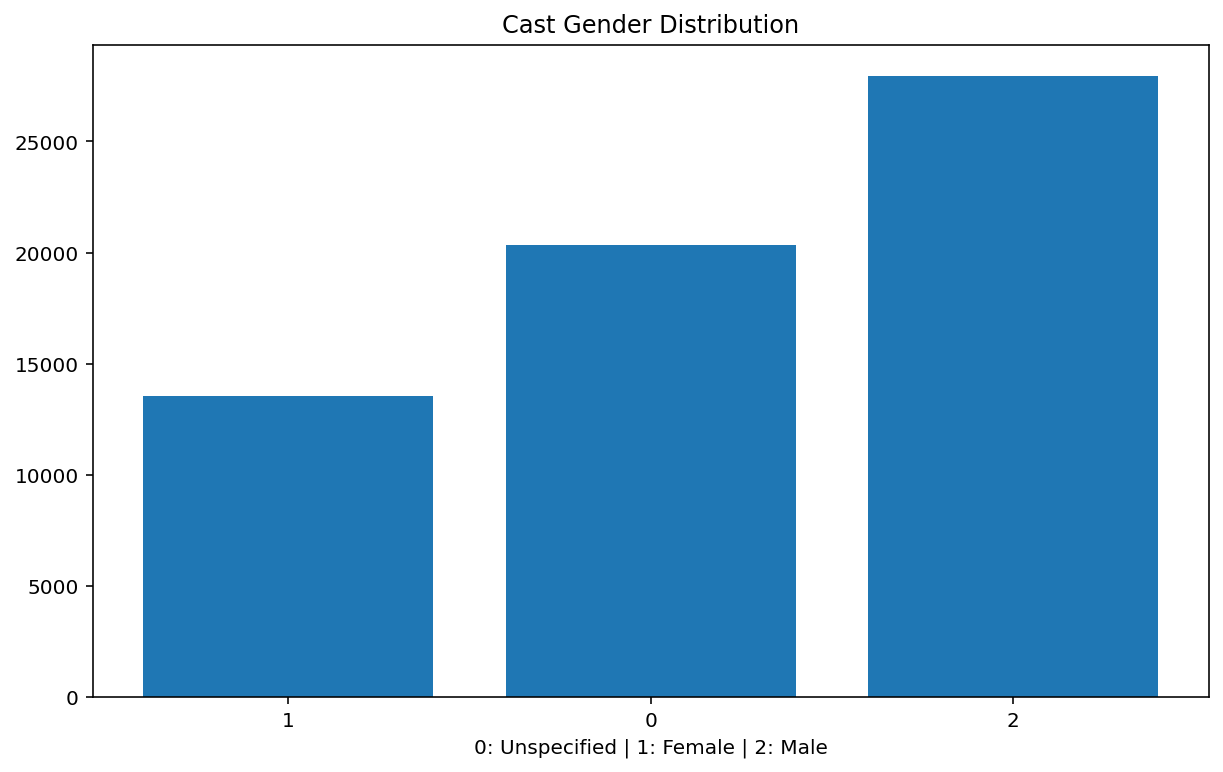

In [142]:
gender_counter = Counter([i for j in list_of_cast_genders for i in j]).most_common()

fig = plt.figure(figsize=(10,6))
data=dict(gender_counter)
names = list(data.keys())
values = list(data.values())

plt.bar(sorted(range(len(data)),reverse=True),values,tick_label=names)
plt.xlabel('0: Unspecified | 1: Female | 2: Male')
plt.title('Cast Gender Distribution')
plt.show()

#### Crew
We would think a film's crew is nearly as important as the cast in generating box office revenues. The data in this column includes crew name, gender, department and job/role. As we have done previously, we will create a column with the number of crew members, and binary columns for gender and the 15 most common crew members, departments, and jobs.

In [143]:
print('Number of crew members in films')
train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of crew members in films


2     179
11    127
3     126
10    126
12    110
8     109
9     109
14    104
4     101
7      94
Name: crew, dtype: int64

In [144]:
#top 15 crew members
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

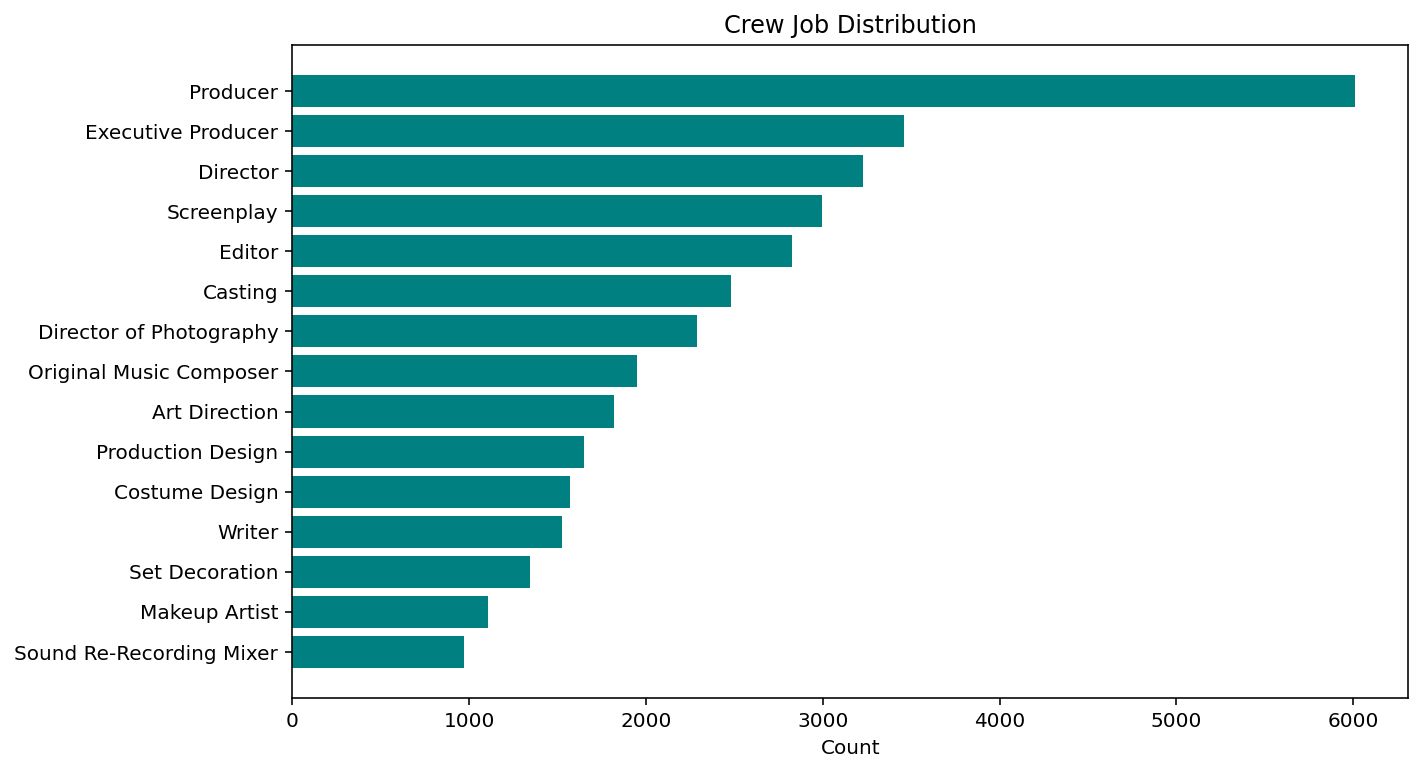

In [145]:
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
crew_jobs_counter = Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

fig = plt.figure(figsize=(10,6))
data=dict(crew_jobs_counter)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='teal')
plt.xlabel('Count')
plt.title('Crew Job Distribution')
plt.show()

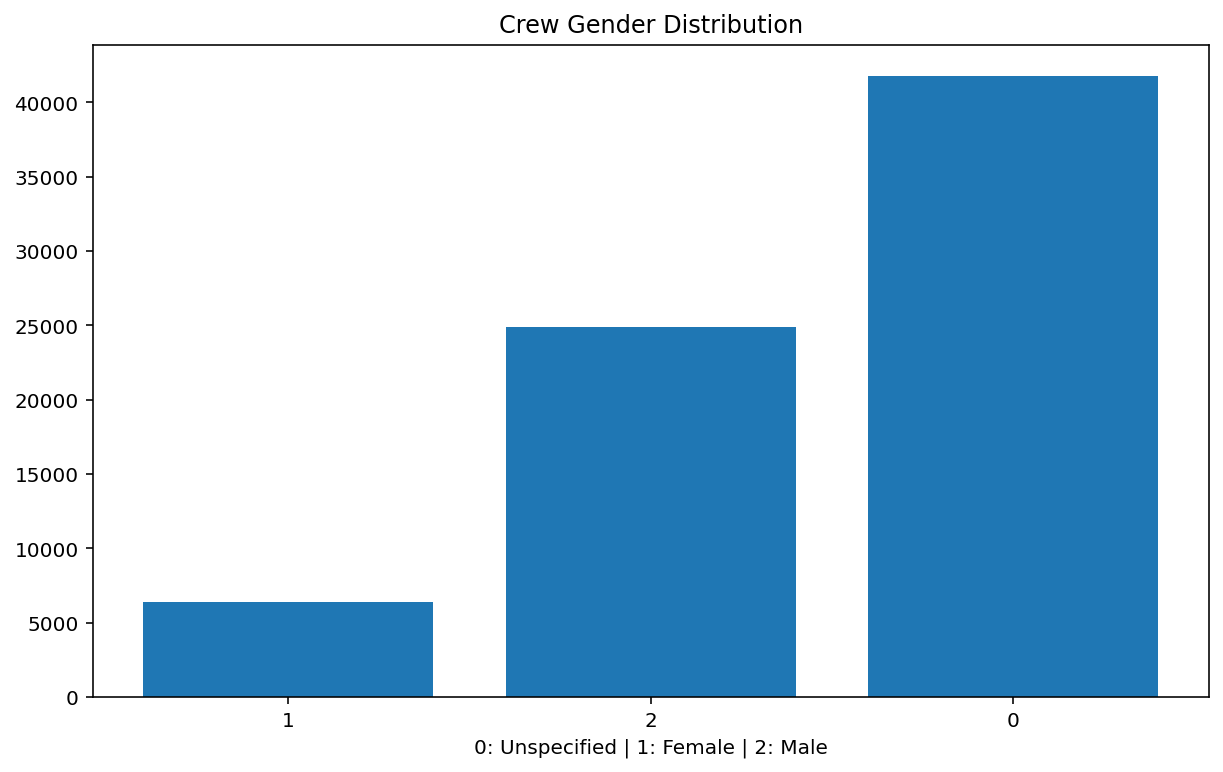

In [146]:
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
crew_gender_counter = Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

fig = plt.figure(figsize=(10,6))
data=dict(crew_gender_counter)
names = list(data.keys())
values = list(data.values())

plt.bar(sorted(range(len(data)),reverse=True),values,tick_label=names)
plt.xlabel('0: Unspecified | 1: Female | 2: Male')
plt.title('Crew Gender Distribution')
plt.show()

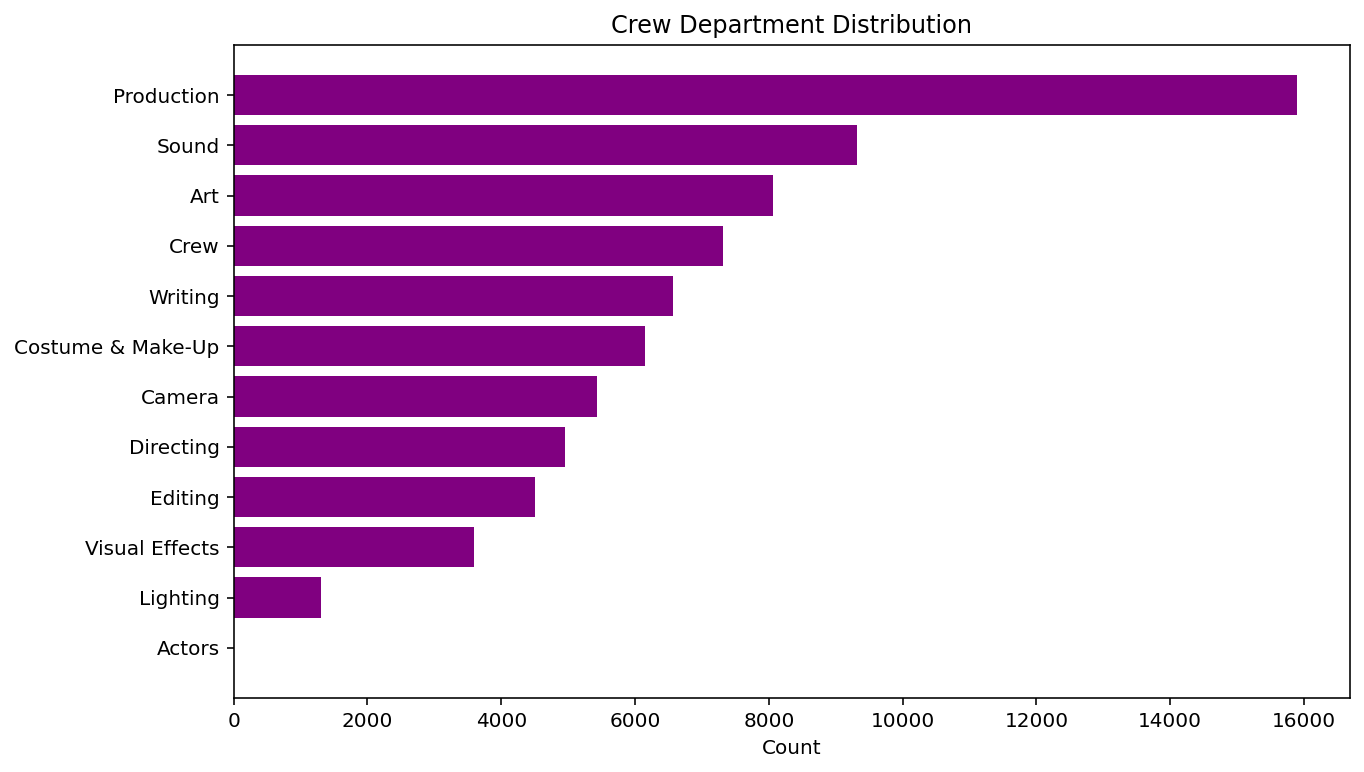

In [147]:
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
crew_dept_counter = Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

fig = plt.figure(figsize=(10,6))
data=dict(crew_dept_counter)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='purple')
plt.xlabel('Count')
plt.title('Crew Department Distribution')
plt.show()

In [148]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_crew_names:
    test['crew_name_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

# Will be interesting to look at revenue and budget by cast/crew members (similar to https://www.kaggle.com/somang1418/eda-lgb-xgb-modelings-with-a-cute-panda-meme#Data-Pre-processing-&-EDA )
### Continue with EDA of other columns

Release Date

In [93]:
#Since only last two digits of year are provided, this is the correct way of getting the year.
train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
# Some rows have 4 digits of year instead of 2, that's why I am applying (train['release_year'] < 100) this condition
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(train['release_date']) 
train['release_dayofweek'] = releaseDate.dt.dayofweek
train['release_quarter'] = releaseDate.dt.quarter

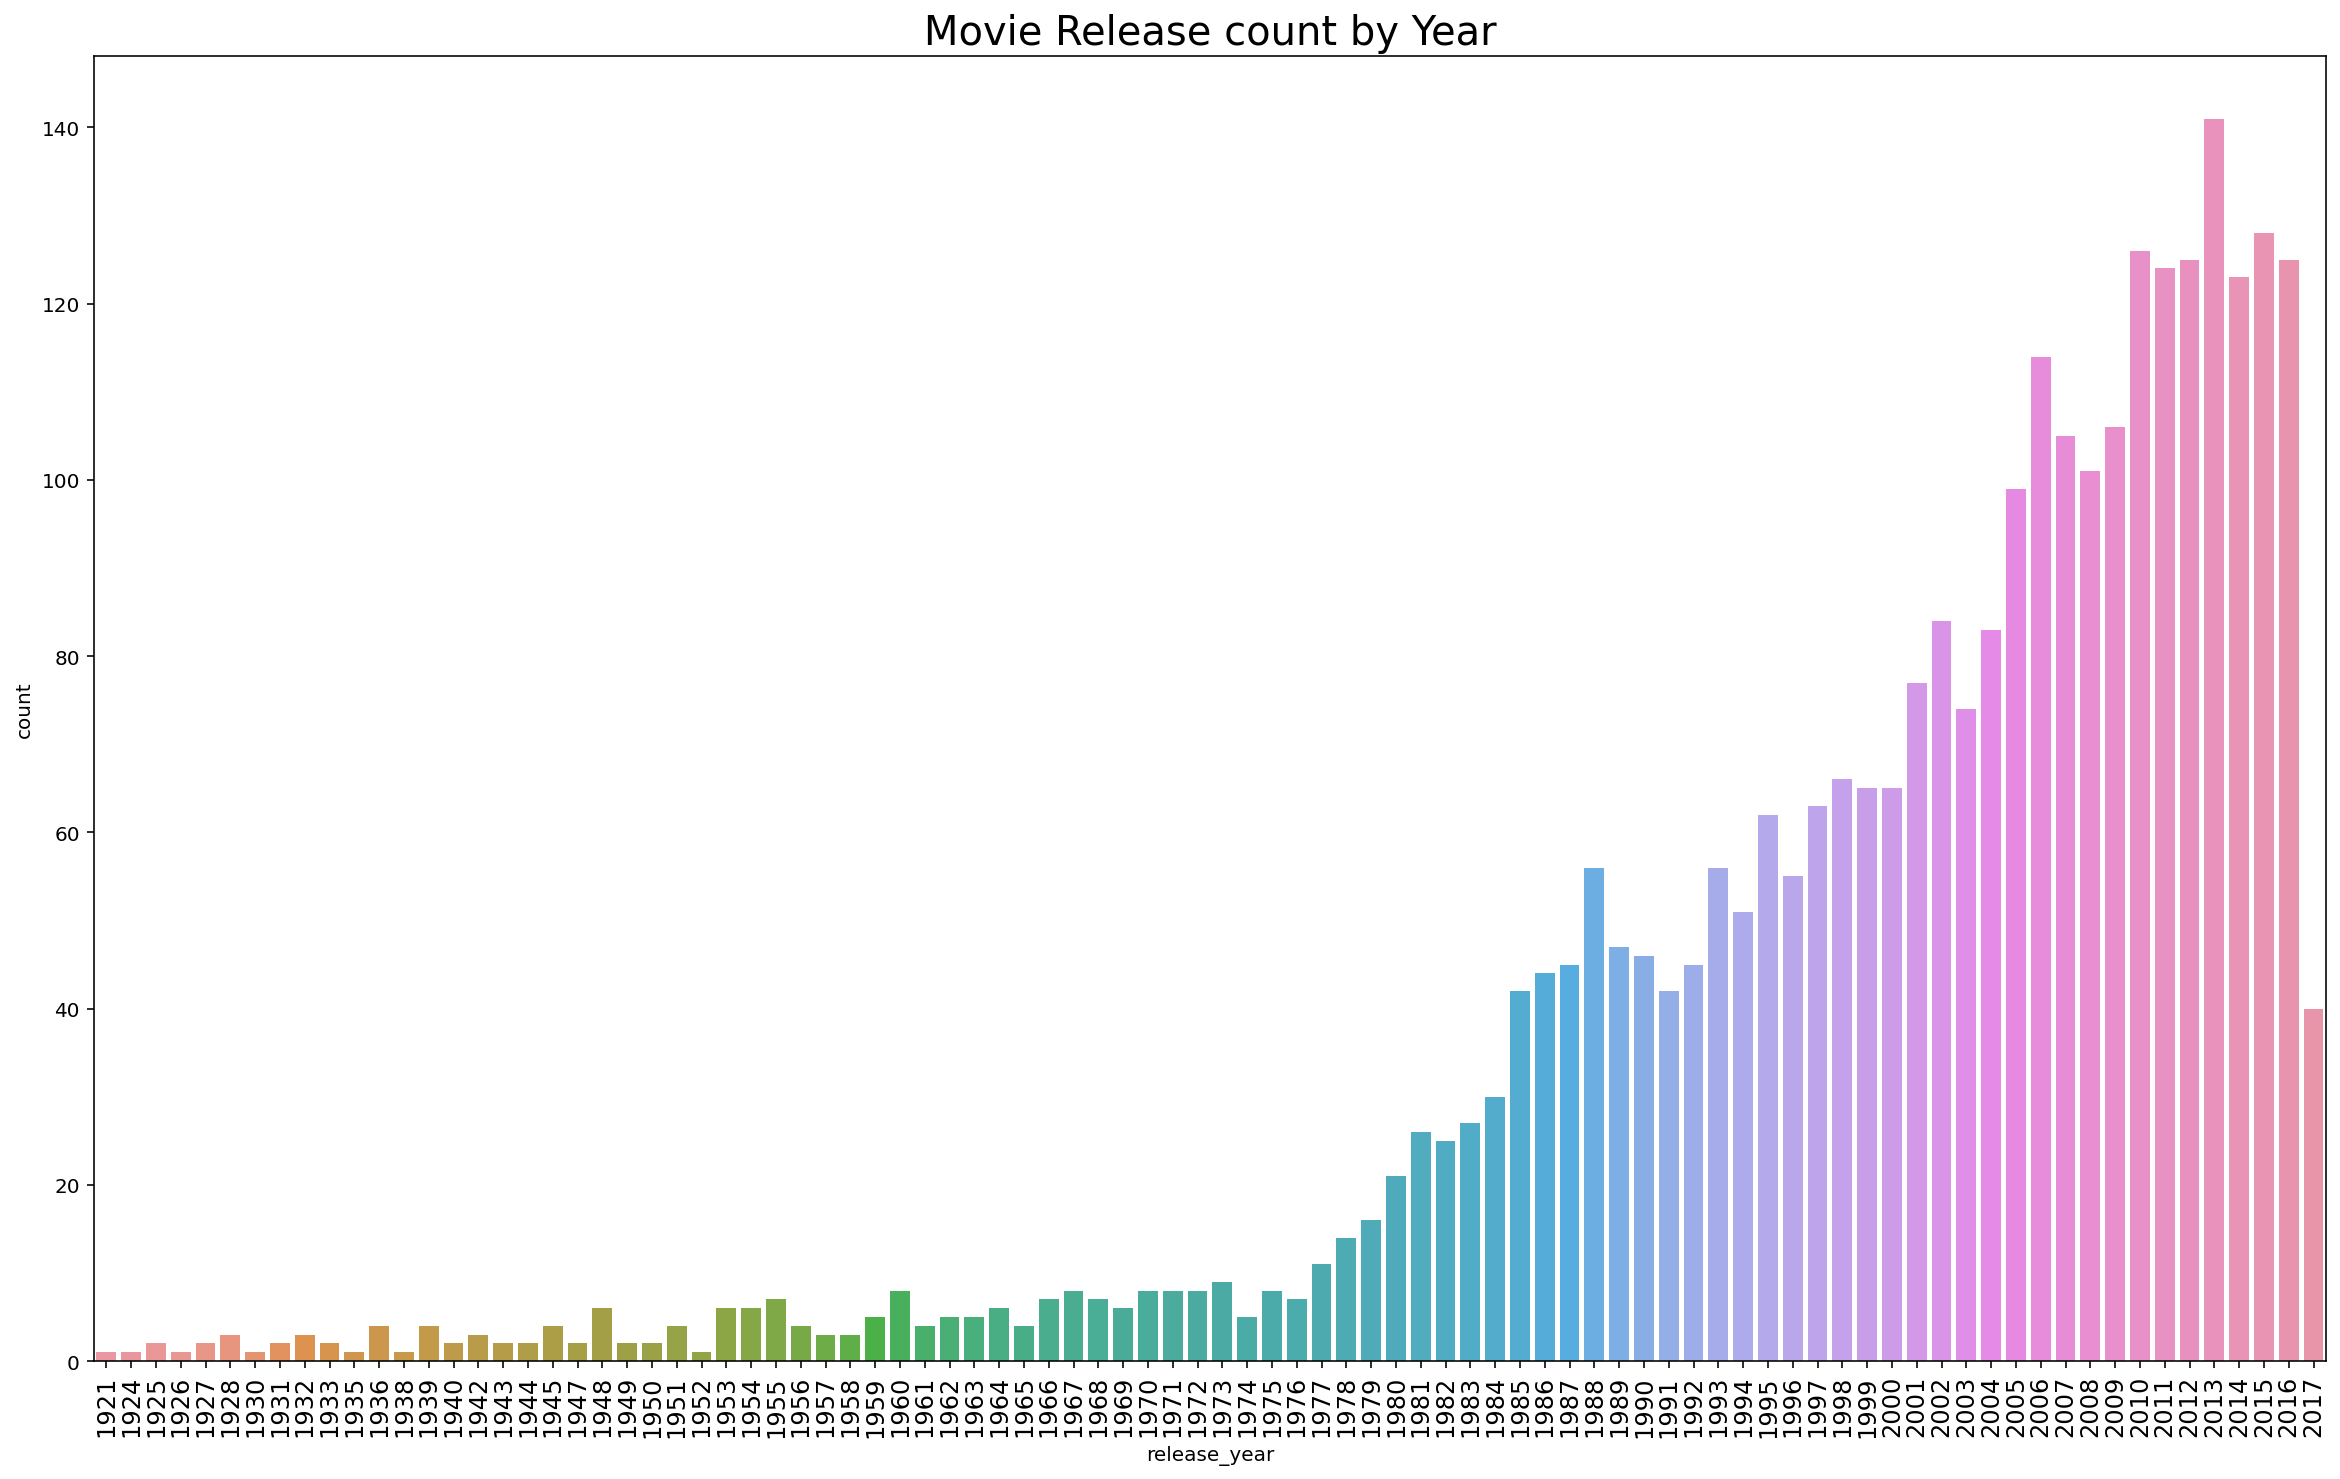

In [96]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_year'].sort_values())
plt.title("Movie Release count by Year",fontsize=20)
loc, labels = plt.xticks()
plt.xticks(fontsize=12,rotation=90)
plt.show()

Revenue (Target Variable) & Budget

<AxesSubplot:xlabel='revenue', ylabel='Density'>

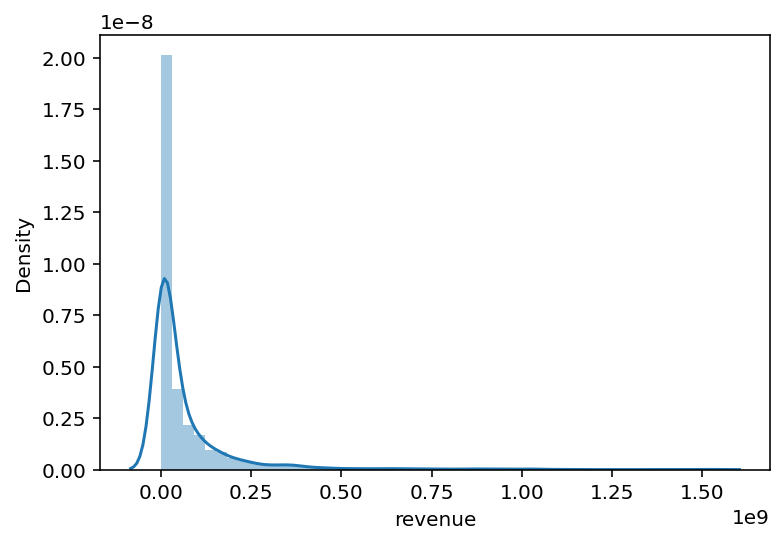

In [86]:
##highly skewed towards lower revenue
sns.distplot(train['revenue'] )

<AxesSubplot:xlabel='logRevenue', ylabel='Density'>

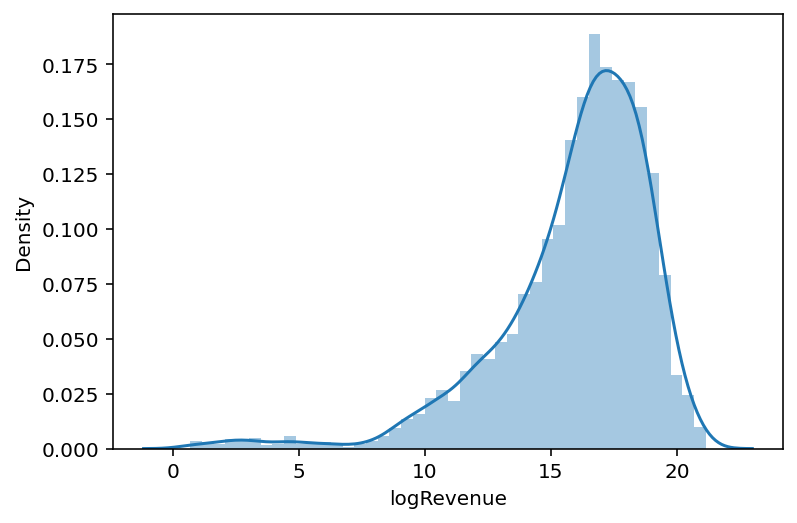

In [87]:
##log of revenue to handle skew
train['logRevenue'] = np.log1p(train['revenue'])
sns.distplot(train['logRevenue'] )

In [99]:
# Putting log variables for skewed data 
train['log_budget']=np.log1p(train['budget'])
test['log_budget']=np.log1p(test['budget'])

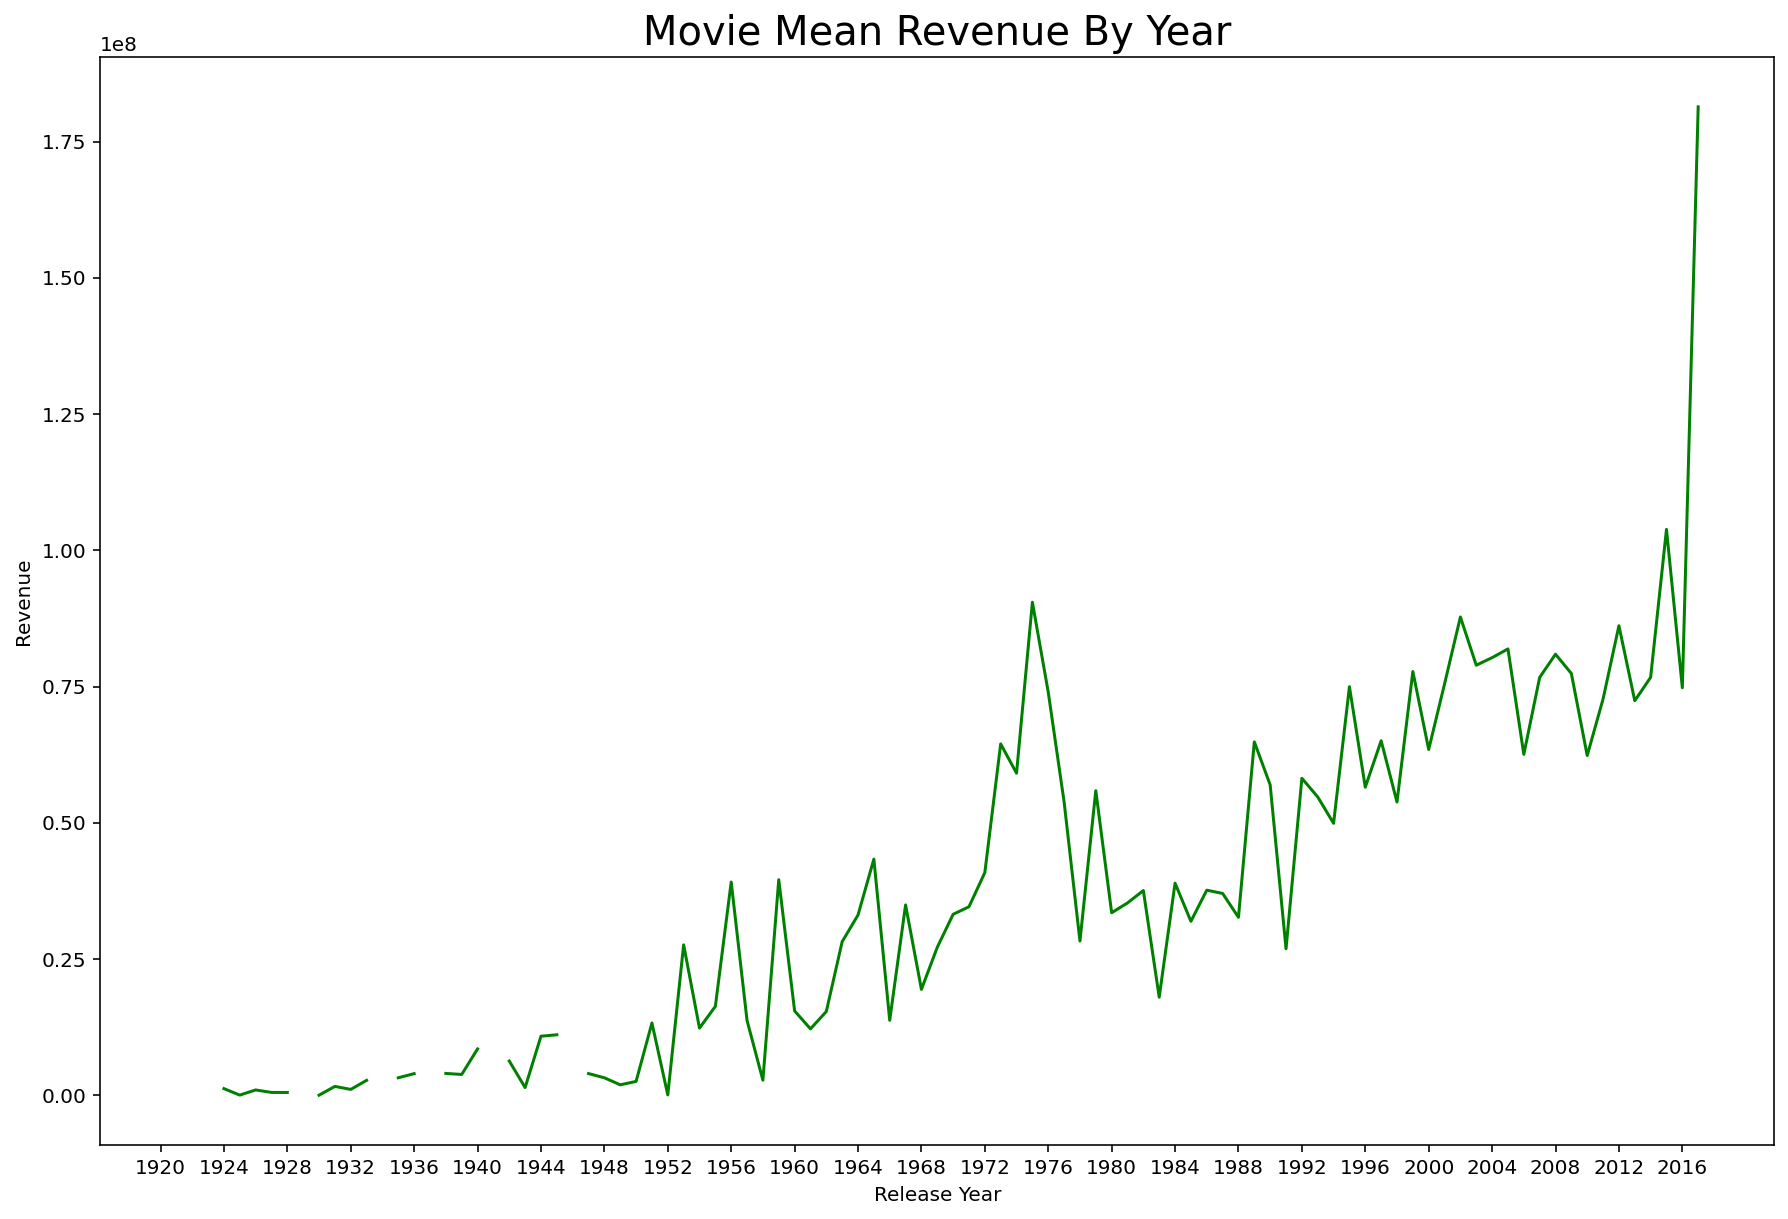

In [94]:
train['meanRevenueByYear'] = train.groupby("release_year")["revenue"].aggregate('mean')
train['meanRevenueByYear'].plot(figsize=(15,10),color="g")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Year",fontsize=20)
plt.show()

In [120]:
# Text analysis on top 4 movie genres title 

drama=train.loc[train['genre_Drama']==1,]
comedy=train.loc[train['genre_Comedy']==1,]
action=train.loc[train['genre_Action']==1,]
thriller=train.loc[train['genre_Thriller']==1,]

drama_revenue=drama.groupby(['release_year']).mean()['revenue']
comedy_revenue=comedy.groupby(['release_year']).mean()['revenue']
action_revenue=action_revenue=action.groupby(['release_year']).mean()['revenue']
thriller_revenue=thriller.groupby(['release_year']).mean()['revenue']

revenue_concat = pd.concat([drama_revenue,comedy_revenue,action_revenue,thriller_revenue], axis=1)
revenue_concat.columns=['drama','comedy','action','thriller']
revenue_concat.index=train.groupby(['release_year']).mean().index


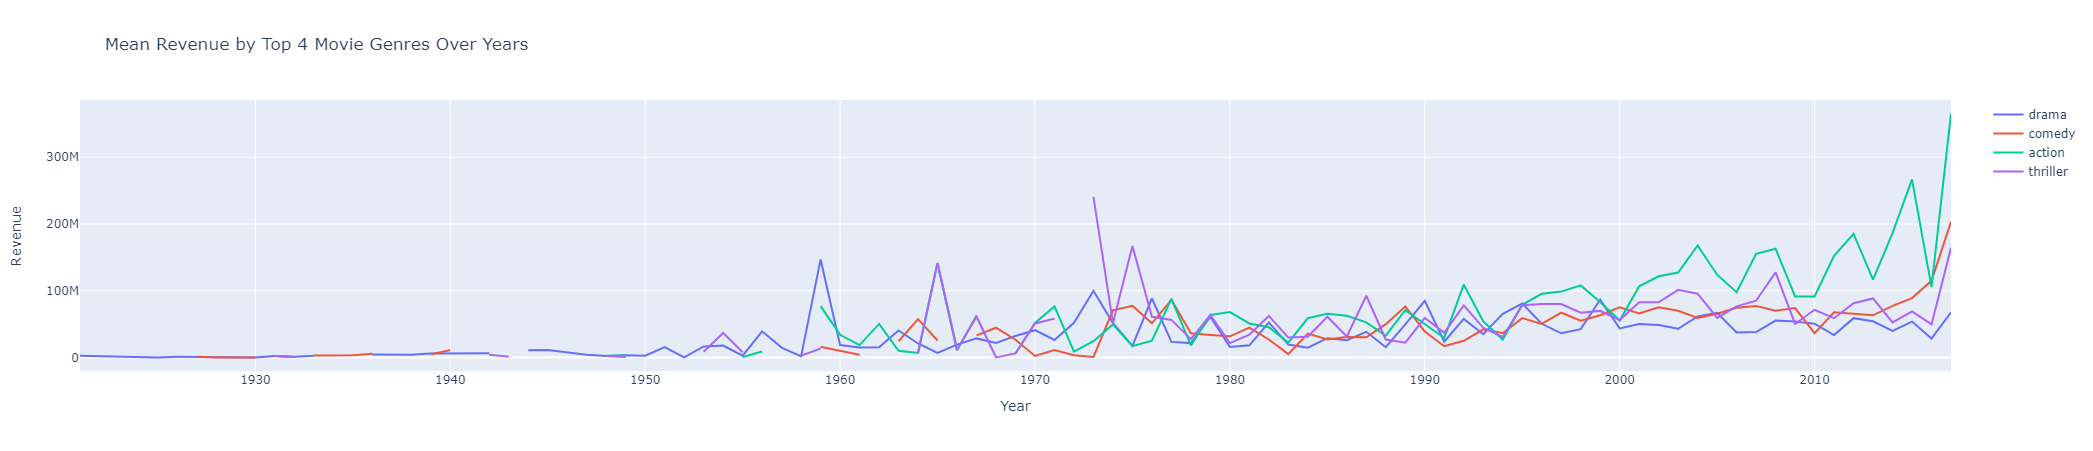

In [121]:
# Mean revenue over years by top 4 genres 

data = [go.Scatter(x=revenue_concat.index, y=revenue_concat.drama, name='drama'), go.Scatter(x=revenue_concat.index, y=revenue_concat.comedy, name='comedy'),
       go.Scatter(x=revenue_concat.index, y=revenue_concat.action, name='action'),go.Scatter(x=revenue_concat.index, y=revenue_concat.thriller, name='thriller')]
layout = go.Layout(dict(title = 'Mean Revenue by Top 4 Movie Genres Over Years',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Revenue'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

Text(0.5, 0, 'Revenue (100 million dollars)')

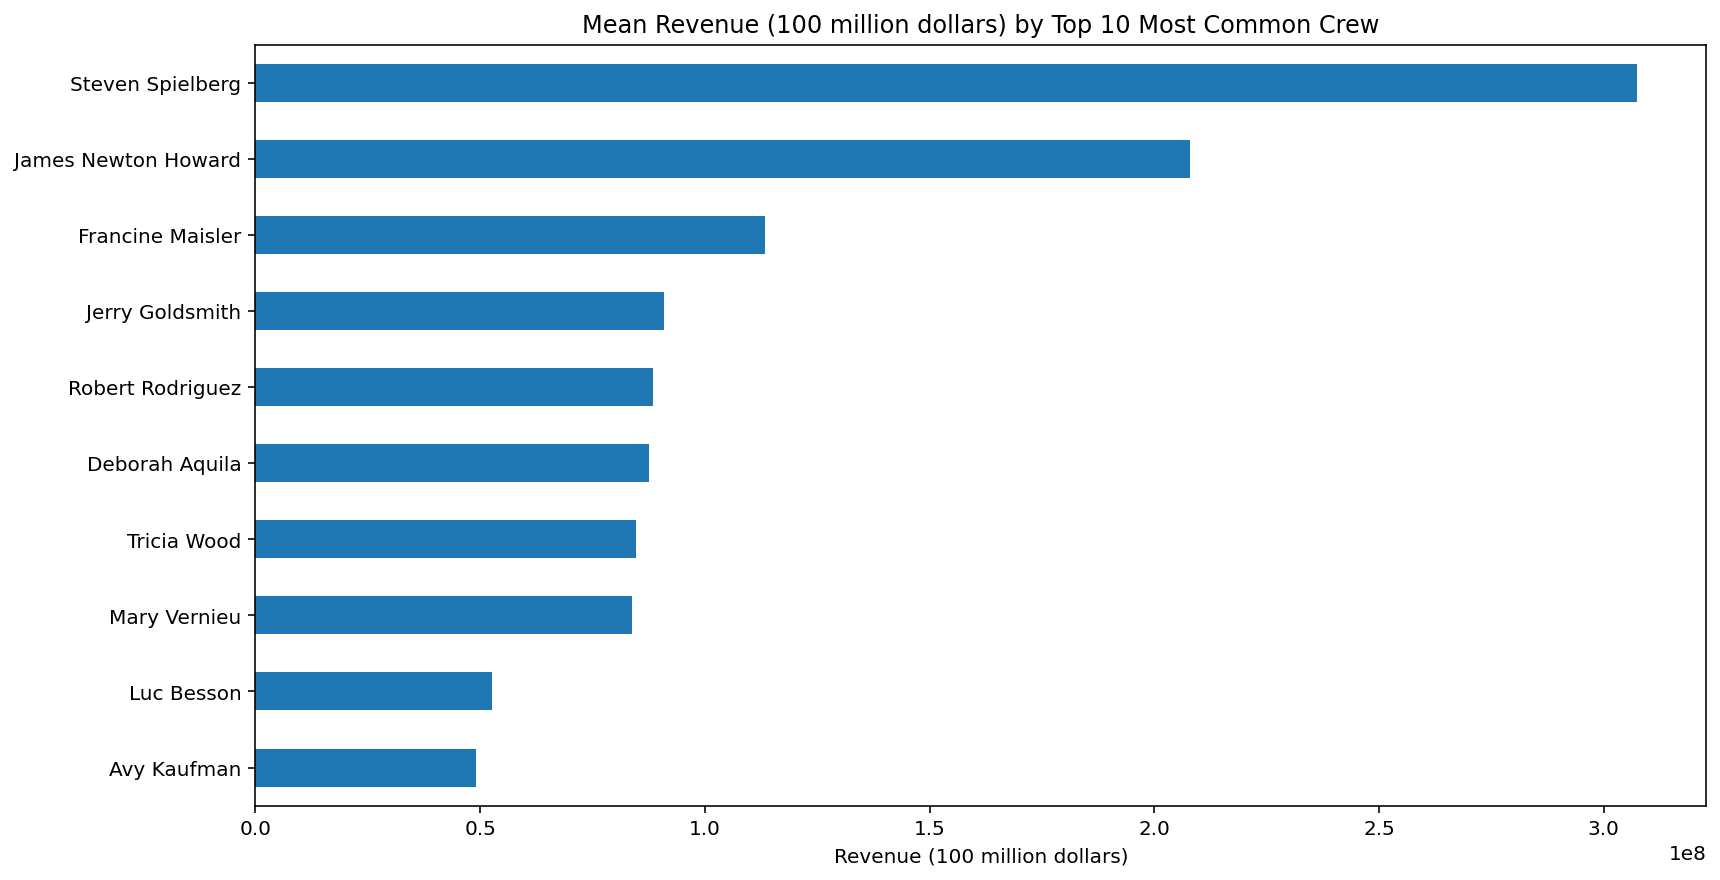

In [149]:
crew_name_Avy_Kaufman=train.loc[train['crew_name_Avy Kaufman']==1,]
crew_name_Robert_Rodriguez=train.loc[train['crew_name_Robert Rodriguez']==1,]
crew_name_Deborah_Aquila=train.loc[train['crew_name_Deborah Aquila']==1,]
crew_name_James_Newton_Howard=train.loc[train['crew_name_James Newton Howard']==1,]
crew_name_Mary_Vernieu=train.loc[train['crew_name_Mary Vernieu']==1,]
crew_name_Steven_Spielberg=train.loc[train['crew_name_Steven Spielberg']==1,]
crew_name_Luc_Besson=train.loc[train['crew_name_Luc Besson']==1,]
crew_name_Jerry_Goldsmith=train.loc[train['crew_name_Jerry Goldsmith']==1,]
crew_name_Francine_Maisler=train.loc[train['crew_name_Francine Maisler']==1,]
crew_name_Tricia_Wood=train.loc[train['crew_name_Tricia Wood']==1,]


crew_name_Avy_Kaufman_revenue=crew_name_Avy_Kaufman.mean()['revenue']
crew_name_Robert_Rodriguez_revenue=crew_name_Robert_Rodriguez.mean()['revenue']
crew_name_Deborah_Aquila_revenue=crew_name_Deborah_Aquila.mean()['revenue']
crew_name_James_Newton_Howard_revenue=crew_name_James_Newton_Howard.mean()['revenue']
crew_name_Mary_Vernieu_revenue=crew_name_Mary_Vernieu.mean()['revenue']
crew_name_Steven_Spielberg_revenue=crew_name_Steven_Spielberg.mean()['revenue']
crew_name_Luc_Besson_revenue=crew_name_Luc_Besson.mean()['revenue']
crew_name_Jerry_Goldsmith_revenue=crew_name_Jerry_Goldsmith.mean()['revenue']
crew_name_Francine_Maisler_revenue=crew_name_Francine_Maisler.mean()['revenue']
crew_name_Tricia_Wood_revenue=crew_name_Tricia_Wood.mean()['revenue']


crew_revenue_concat = pd.Series([crew_name_Avy_Kaufman_revenue,crew_name_Robert_Rodriguez_revenue,crew_name_Deborah_Aquila_revenue,crew_name_James_Newton_Howard_revenue,
                                crew_name_Mary_Vernieu_revenue,crew_name_Steven_Spielberg_revenue,crew_name_Luc_Besson_revenue,crew_name_Jerry_Goldsmith_revenue,
                                crew_name_Francine_Maisler_revenue,crew_name_Tricia_Wood_revenue])
crew_revenue_concat.index=['Avy Kaufman','Robert Rodriguez','Deborah Aquila','James Newton Howard','Mary Vernieu','Steven Spielberg','Luc Besson','Jerry Goldsmith',
                            'Francine Maisler','Tricia Wood']


fig = plt.figure(figsize=(13, 7))
crew_revenue_concat.sort_values(ascending=True).plot(kind='barh',title='Mean Revenue (100 million dollars) by Top 10 Most Common Crew')
plt.xlabel('Revenue (100 million dollars)')

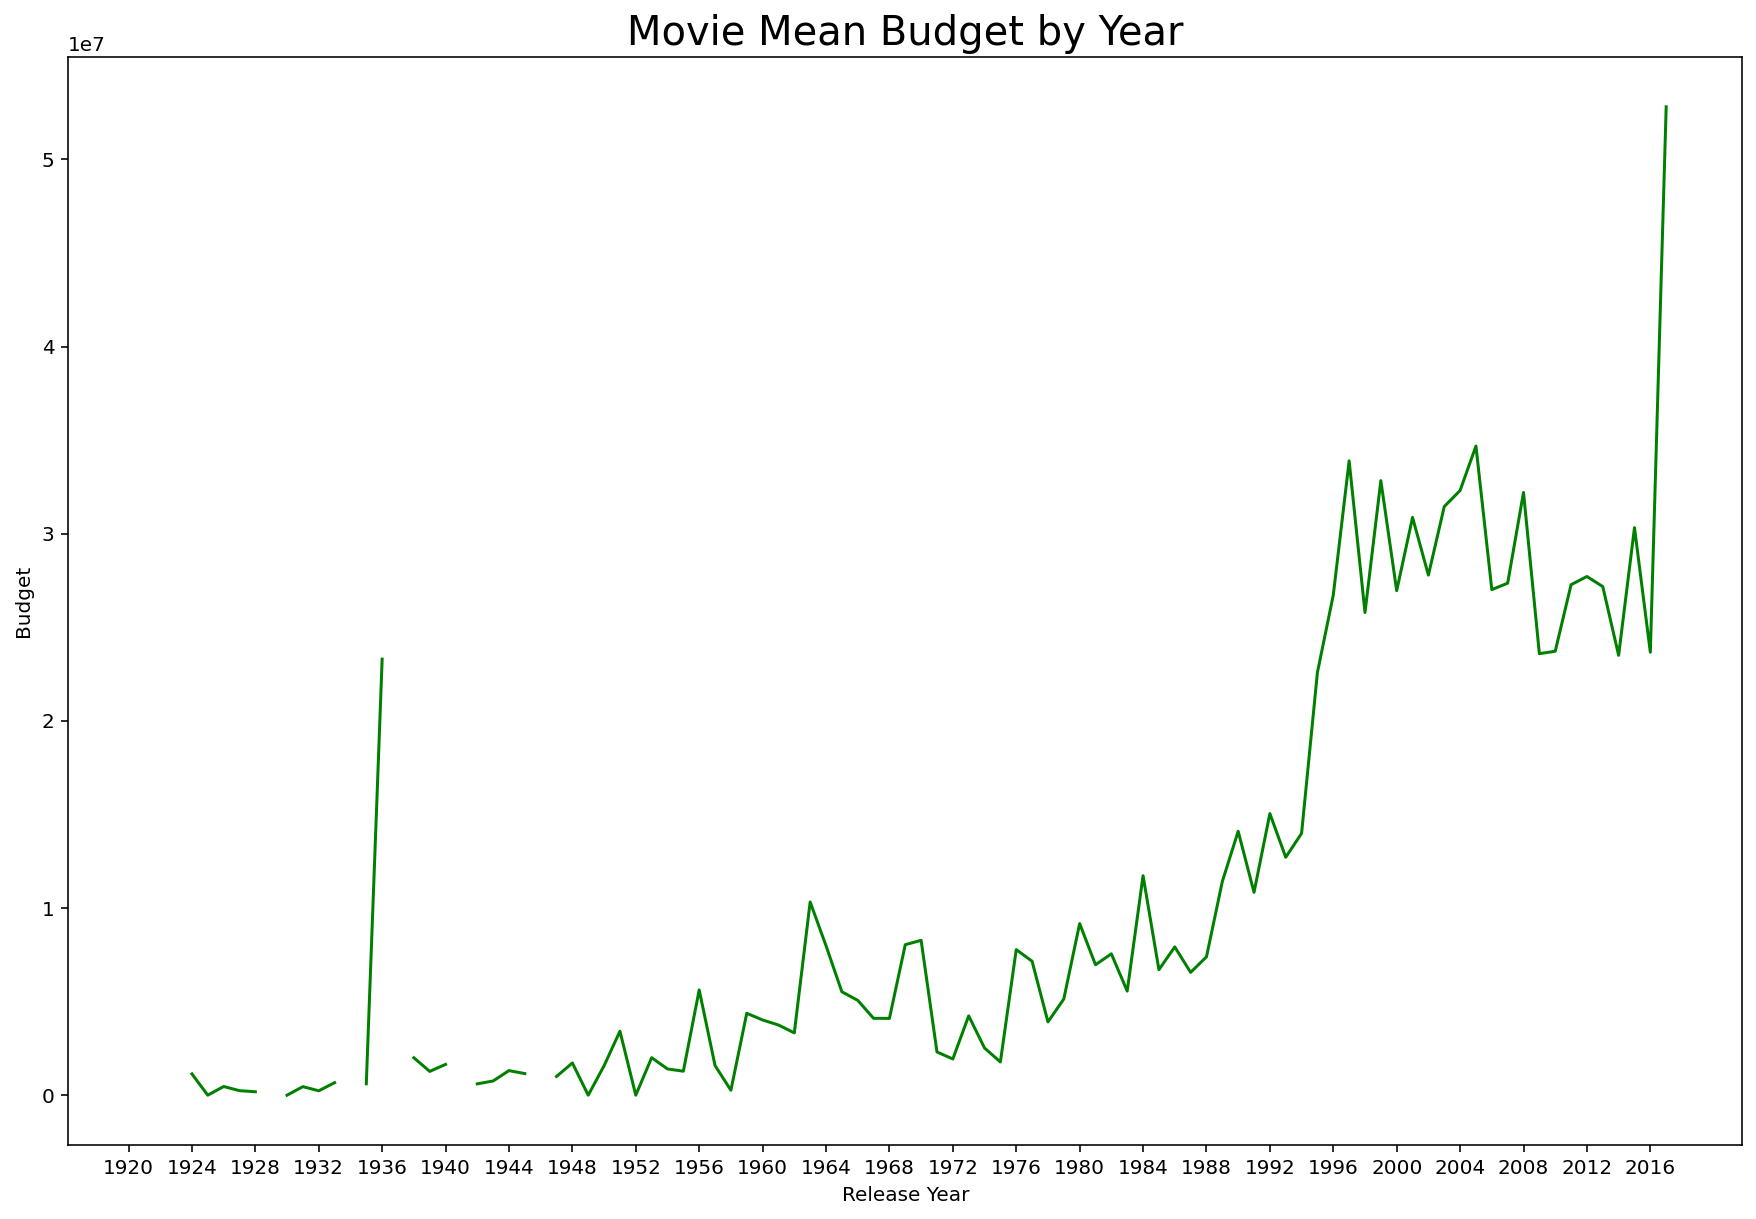

In [100]:
train['meanBudgetByYear'] = train.groupby("release_year")["budget"].aggregate('mean')
train['meanBudgetByYear'].plot(figsize=(15,10),color="g")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Budget")
plt.title("Movie Mean Budget by Year",fontsize=20)
plt.show()

In [101]:
##budget and revenue highly correlated
np.corrcoef(train['budget'], train['revenue'])

array([[1.      , 0.754983],
       [0.754983, 1.      ]])

<AxesSubplot:>

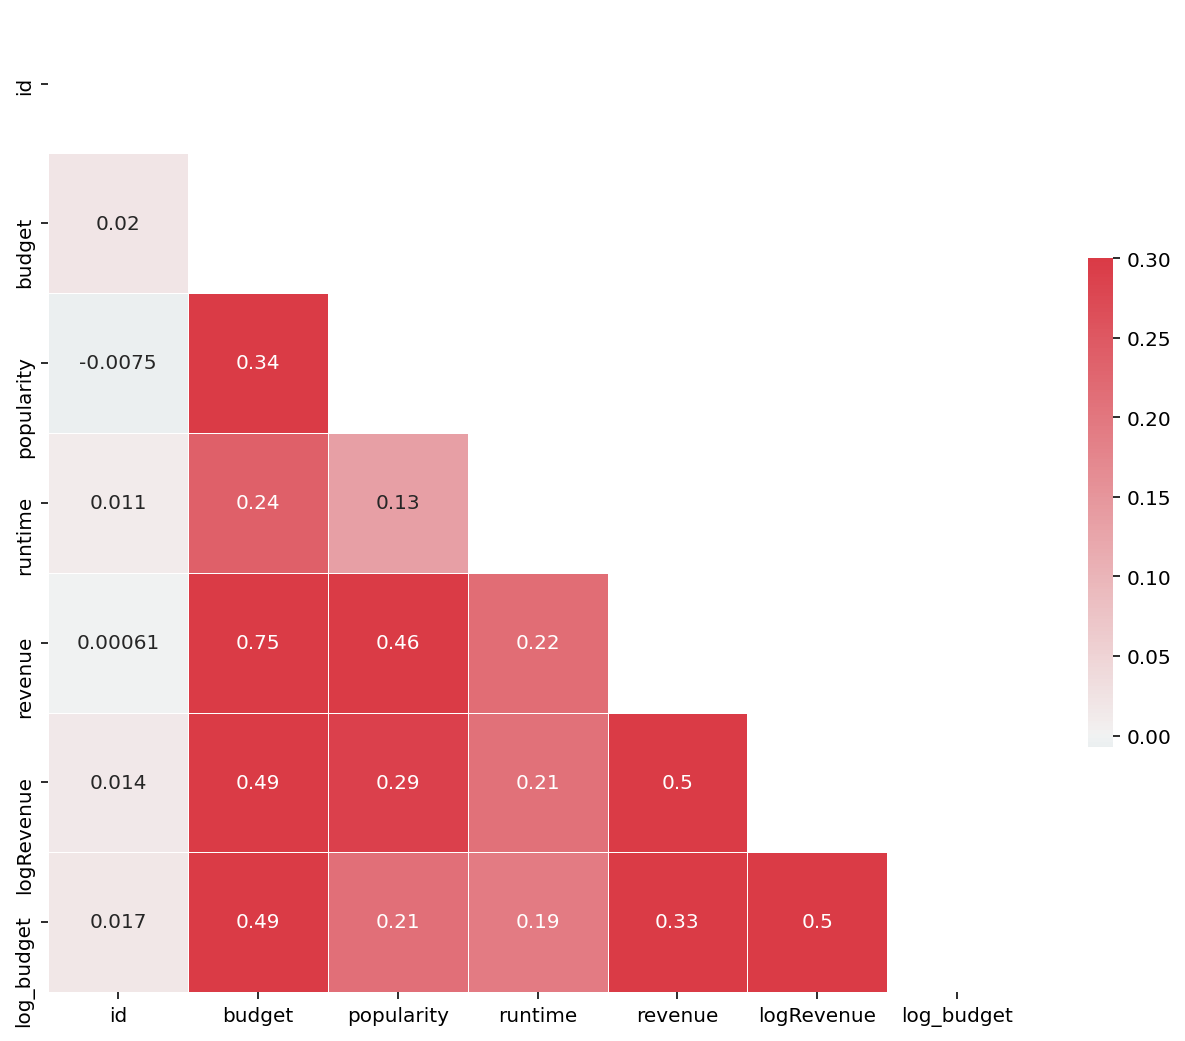

In [90]:
##lets see correlation for all numeric variables
# Creating correlation matrix 

corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
Popularity

In [ ]:
train['log_popularity']=np.log1p(train['popularity'])
test['log_popularity']=np.log1p(test['popularity'])

Text(0.5, 1.0, 'Mean Popularity Over Years')

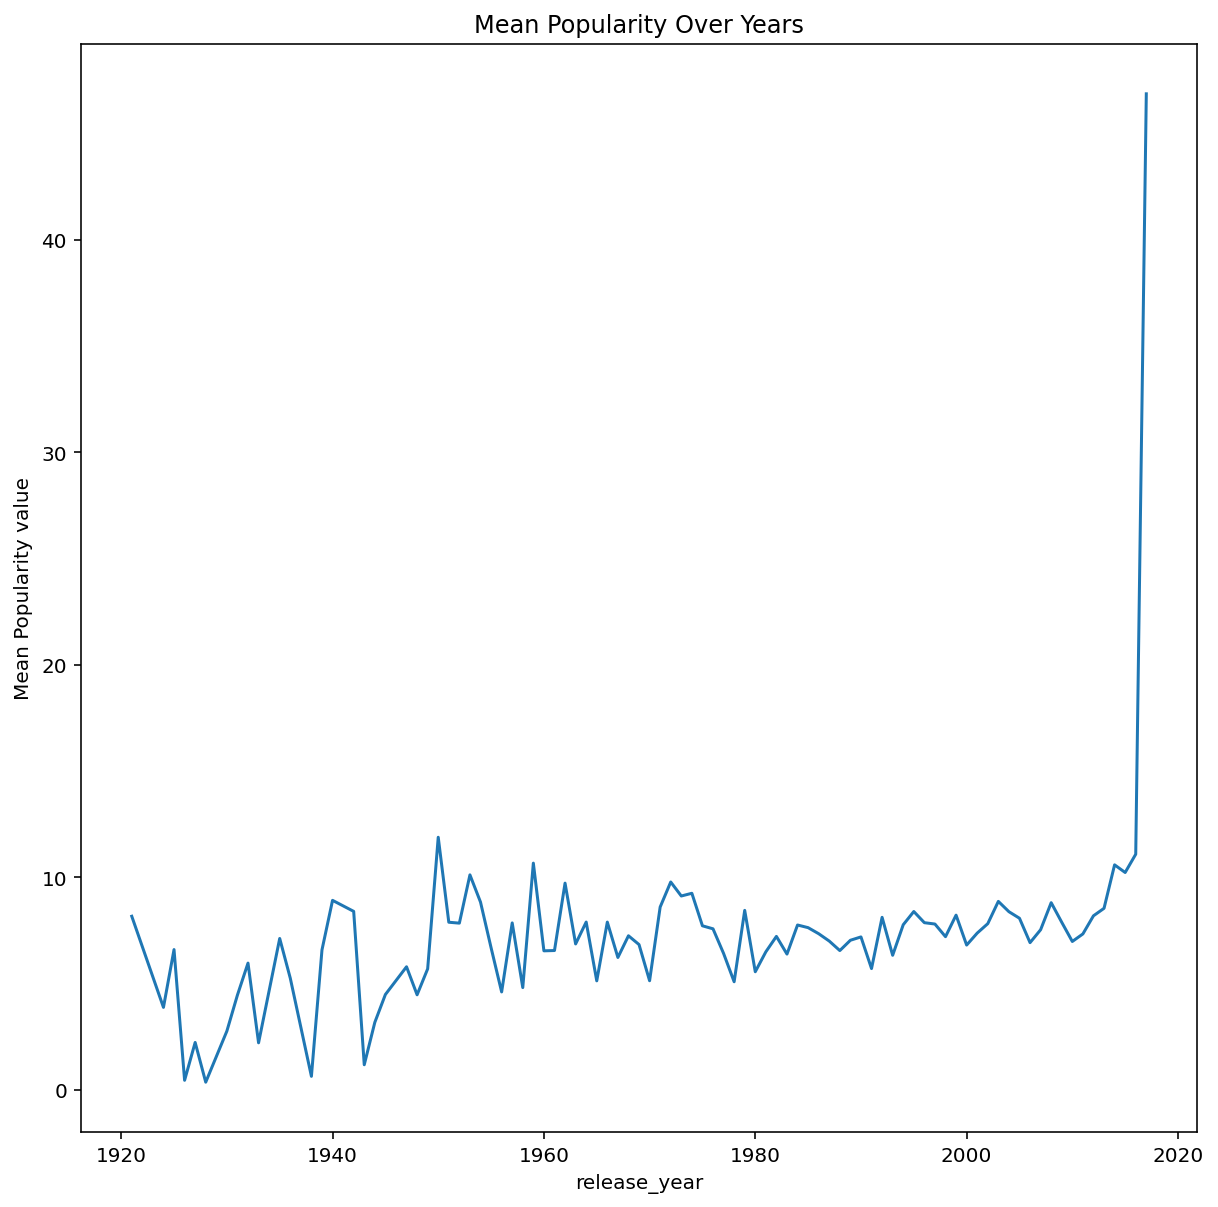

In [69]:
release_year_mean_data=train.groupby(['release_year'])['budget','popularity','revenue'].mean()
release_year_mean_data.head()

fig = plt.figure(figsize=(10, 10))
release_year_mean_data['popularity'].plot(kind='line')
plt.ylabel('Mean Popularity value')
plt.title('Mean Popularity Over Years')

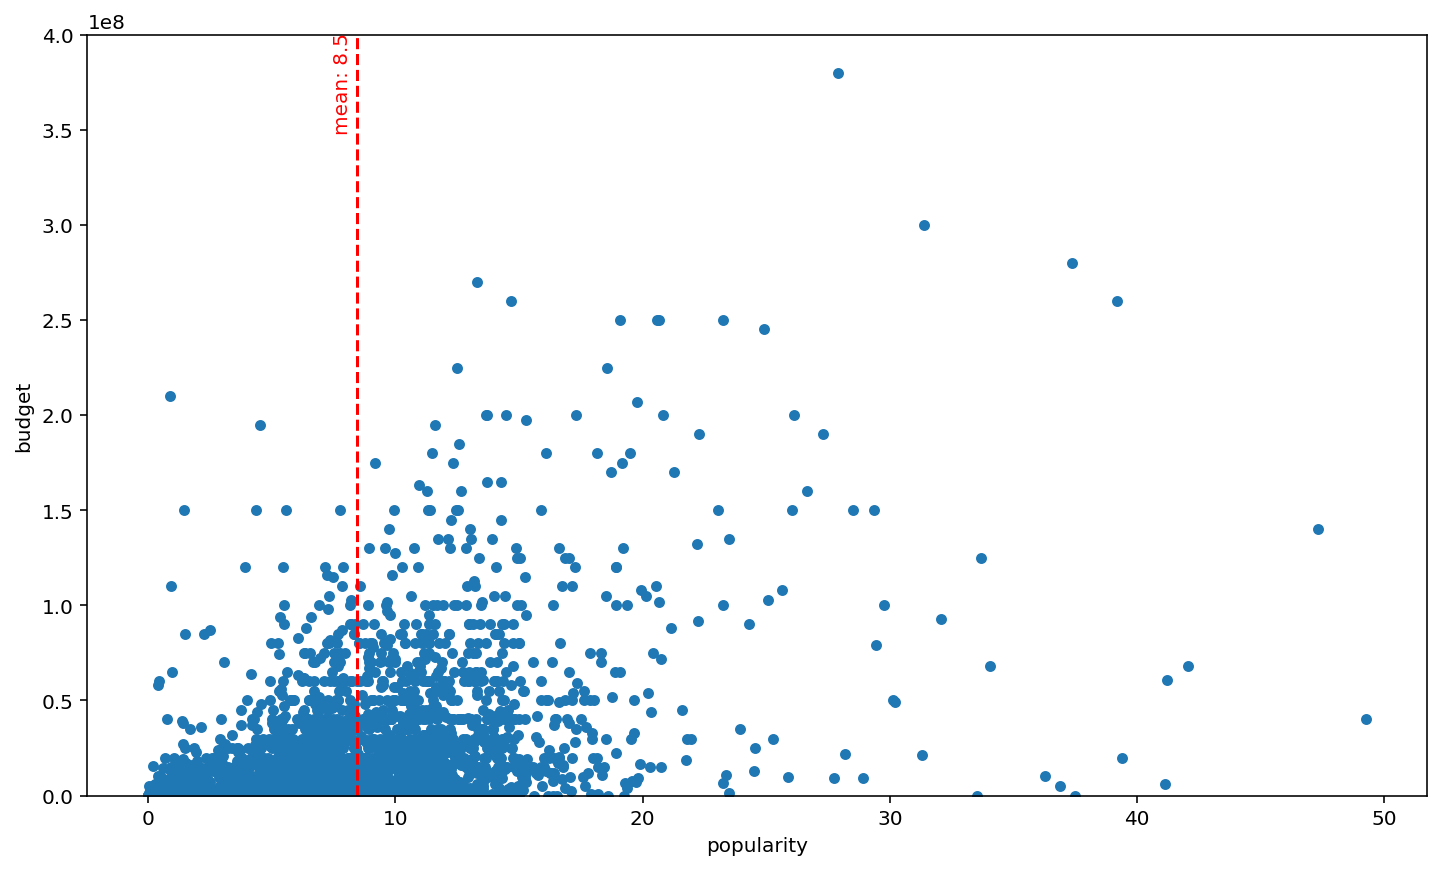

In [151]:
pop = train[train.popularity<50]
pop_mean = np.mean(train.popularity)
pop.plot(x="popularity",y="budget", kind="scatter",figsize=(12,7))
plt.axvline(x=pop_mean, c="red", linestyle="--")
plt.text(pop_mean-1, 3.5e8,"mean: {0:0.1f}".format(pop_mean), color="red", rotation=90)
plt.ylim([0,4e8])
plt.show()